In [10]:
# -*- coding: utf-8 -*-
# learning & evaluation

# learning 
## author: Cheng Zheng
# evaluation
## author: Cheng Zheng & Sunny Qu

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Machine learning algorithms
from sklearn.linear_model import RidgeClassifier  # Ridge regression
from sklearn.kernel_ridge import KernelRidge  # Kernel ridge regression
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier  # AdaBoost & Random Forest
from sklearn.neural_network import MLPClassifier  # Neural network
from sklearn.svm import SVC  # Support vector machine

# Cross-validation
'''
GridSearchCV = Perform an optimization of the parameters.
                1. search for the best parameters for model; 
                2. automatically fit a new model on the training dataset w/ the parameters that 
                    can yield the best cross-validation performance.
cross_val_score = to implement cross-validation in scikit-learn.
PS: When an integer is passed to the cv parameter of cross_val_score():
    cv=int (same as cv=StratifiedKFold(n_splits=int)) is used if the estimator is a classifier 
    and y is either binary or multiclass; In all other cases, KFold is used.
'''
from sklearn.model_selection import GridSearchCV

# Metrics
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report

import warnings
warnings.filterwarnings("ignore")

path = os.getcwd()#get current path
path_project = os.path.dirname(path)#go up one directory

In [11]:
#################
# main class to do all the learning and evaluation part
class learning(object): 
    
    def __init__(self, alg, rule, loadfile, savefile):
        # alg=algorithm; rule=evaluation method; loadfile=preprocessed data excel; savefile=folder to store plots
        self.alg = alg
        self.rule = rule
        self.loadfile = loadfile
        self.savefile = savefile

    def param(self):
        # i=check what y sets: Total Area(0) vs MVPA(1) vs IPAQ(2). 
        # j=check how many variables in X: 1(0) vs 5/6(1).
        # k=check preprocessing method, aka StandardScaler(0) vs MinMaxScaler(1) vs RobustScaler(2) vs NoScaler(3)
        i = 1 if ('y_MVPA' in self.savefile) else (2 if ('y_IPAQ' in self.savefile) else 0) 
        j = 0 if ('_x' in self.savefile) else 1 
        k = 0 if ('standard' in self.savefile) else (1 if ('minMax' in self.savefile) else (2 if ('robust' in self.savefile) else 3))
        return i, j, k
    
    # Import dataset
    def loadDatasets(self):
        dataset = pd.read_excel(path_project+self.loadfile)#to import the preprocessed dataset into a variable
        i = self.param()[0]
        j = self.param()[1]
        
        y = dataset['MVPA'] if i == 1 else (dataset['IPAQ'] if i == 2 else dataset['aveTotalArea'])
        if (i == 0):
            if (j == 1):
                X = pd.DataFrame(dataset.loc[:,['aveML_RMS','aveDisplacement','aveVelocity','aveAP_RMS','MVPA','IPAQ']])
            else:
                X = dataset['MVPA'].values.reshape(-1, 1) if ('x_MVPA' in self.savefile) else dataset['IPAQ'].values.reshape(-1, 1)
        else:
            X = pd.DataFrame(dataset.loc[:,['aveML_RMS','aveDisplacement','aveVelocity','aveAP_RMS','aveTotalArea']]) if j == 1 else dataset['aveTotalArea'].values.reshape(-1, 1)
        other = pd.DataFrame(dataset.iloc[:,:4])
        
        return X, y, other, path_project

    # Which algorithm
    def algorithm(self):
        alg_dict = {
            'ridge': RidgeClassifier(),
            'kr': KernelRidge(),
            'svm': SVC(),
            'nn': MLPClassifier(),
            'rf': RandomForestClassifier(),
            'ab': AdaBoostClassifier(),
        }
        model = alg_dict.get(self.alg)
            
        return model
        
    # Set param_grid, aka the main parameters in dict
    def param_grid(self):
        '''
        np.logspace = to create geometric series, start and end w/ powers of 10, 
                      i.e. logspace(-2,1,4): a geometric sequence starts w/ 10^-2, ends w/ 10^1, and contains 4 elements.
        np.arange = also to create an arithmetic array, 
                      i.e. arange(1,12,5)): a arithmetic array looks like [1, 6, 11].
        '''
        a = 10.0 ** -np.arange(1, 7)
        
        param_grid_dict = {
            'ridge': [
                {'alpha':np.logspace(-6,6,13)},
                {'alpha':np.arange(1,1001,100)}
            ],
            
            'kr': [
                {'kernel':['rbf'],
                 'gamma':np.logspace(-2,2,5),
                 'alpha':np.logspace(-6,6,13)},
                {'kernel':['linear'],
                 'alpha':np.logspace(-6,6,13)}
            ],
            
            'svm': [
                {'kernel': ['linear'],
                 'C': np.logspace(0,3,4),
                 'coef0': np.linspace(0,5,10)},
                {'kernel': ['rbf'],
                 'gamma': np.logspace(-10,1,20),
                 'C': np.logspace(0,3,4),
                 'coef0': np.linspace(0,5,10)},
            ],
            
            'nn': 
                {'alpha': a,
                 'max_iter': [10000]}
            ,
            
            'rf': 
                {'n_estimators':np.arange(10,101,10),
                 'max_features':np.arange(0.1,1.1,0.1),
                 'max_depth':np.arange(1,11),
                 #'min_samples_split':np.arange(2,10),
                 'bootstrap':[True,False]}
            ,
            
            'ab': 
                {'n_estimators':np.arange(10,201,10),
                 'learning_rate':np.arange(0.1,1.1,0.1)}
            ,
        }
        param_grid = param_grid_dict.get(self.alg)

        return param_grid

        
    # GridSearchCV to find optimal parameters
    def gridSearchCV_eval(self):
        i = self.param()[0]
        j = self.param()[1]
        k = self.param()[2]
        
        i_ = 'y_MVPA' if i == 1 else ('y_IPAQ' if i == 2 else 'y_totalArea')
        if (j == 0):
            j_ = 'x_MVPA' if ('x_MVPA' in self.savefile) else ('x_IPAQ' if ('x_IPAQ' in self.savefile) else 'x_totalArea')
        else:
            j_ = '6Xs' if i == 0 else '5Xs'
        k_ = 'standard' if k == 0 else ('minMax' if k == 1 else ('robust' if k == 2 else 'noScaler'))
        
        X = self.loadDatasets()[0]
        y = self.loadDatasets()[1] if ((self.alg == 'ridge') or (self.alg == 'kr')) else self.loadDatasets()[1].values.ravel()
        
        grid = GridSearchCV(estimator=self.algorithm(), # algorithm
                            param_grid=self.param_grid(), # specify the parameters to search over using a dict
                            cv=10, # 10-Fold
                            scoring=self.rule # evaluation method
                            )

        # Build the model, aka training the dataset
        grid.fit(X, y)
        y_pred = grid.predict(X)
        
        y_test = sorted(y)
        
        # Output the evaluation score
        
        if (self.rule == None):
            confusion = confusion_matrix(y_test, y_pred)
            print('Confusion Matrix\n')
            f1.write('Confusion Matrix\n')
            print(confusion)

            print('\nAccuracy: {:.2f}\n'.format(accuracy_score(y_test, y_pred)))
            f1.write('\nAccuracy: {:.2f}\n'.format(accuracy_score(y_test, y_pred)))

            print('Micro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='micro')))
            print('Micro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='micro')))
            print('Micro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='micro')))
            f1.write('Micro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='micro')))
            f1.write('Micro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='micro')))
            f1.write('Micro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='micro')))

            print('Macro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='macro')))
            print('Macro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='macro')))
            print('Macro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='macro')))
            f1.write('Macro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='macro')))
            f1.write('Macro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='macro')))
            f1.write('Macro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='macro')))

            print('Weighted Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='weighted')))
            print('Weighted Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='weighted')))
            print('Weighted F1-score: {:.2f}'.format(f1_score(y_test, y_pred, average='weighted')))
            f1.write('Weighted Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='weighted')))
            f1.write('Weighted Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='weighted')))
            f1.write('Weighted F1-score: {:.2f}'.format(f1_score(y_test, y_pred, average='weighted')))

            print('\nClassification Report\n')
            print(classification_report(y_test, y_pred, target_names=['Class 1', 'Class 2', 'Class 3']))
            f1.write('\nClassification Report\n')
            f1.write(classification_report(y_test, y_pred, target_names=['Class 1', 'Class 2', 'Class 3']))
        
        else:       
            print("\nBest score in %s: {:.2f}".format(grid.best_score_) %self.rule)
            f1.write("\nBest score in %s: {:.2f}".format(grid.best_score_) %self.rule)
#         print("Best parameter: {}".format(grid.best_params_))
#         print("Best estimator: {}".format(grid.best_estimator_))
#         print("Average score in 10-Fold: \n", grid.cv_results_['mean_test_score'])
#         print("Std score in 10-Fold: \n", grid.cv_results_['std_test_score'])
#         print("The Index of Best estimator: {}".format(grid.best_index_))
        
        #######################
        # Draw the plot w/ y_true VS y_pred
#         if (self.rule == 'r2'):
#             f1.write("\n")
# #             ave_score_cv = cross_val_score(grid, X, y, cv=10, scoring=self.rule).mean()
# #             print("average r2 score in 10-Fold: ", ave_score_cv)
#             yhat = grid.predict(X)
#             sorted(y)

#             plt.figure(dpi=100)
#             plt.title("Scatter Plot: %s %s %s %s OE" %(self.algorithm(),i_,j_,k_))
#             plt.scatter(x=y, y=yhat, alpha=0.25)
#             plt.xlabel('Actual') 
#             plt.ylabel('Predicted')
# #             plt.xticks(range(-1,9,1)) # set the x axis in certain range
# #             plt.yticks(range(-1,11,1)) # set the y axis in certain range
# #             plt.xlim(xmin=-0.5, xmax=1.5) #for smaller scale in x axis, aka cut the graph
# #             plt.ylim(ymin=-0.5, ymax=1.5) #for smaller scale in y axis, aka cut the graph
#             plt.grid(True)
#             plt.savefig(path_project+self.savefile+'/scatter_%s_%s_%s_%s_OE.png' %(self.algorithm(),i_,j_,k_))
#             plt.show()

    '''
    # 10-Fold cross-validation to check its accuracy
    def cross_val(self): 
        X = self.loadDatasets()[0]
        if (self.alg == 'ridge' or self.alg == 'kr'):
            y = self.loadDatasets()[1]
        else:
            y = self.loadDatasets()[1].values.ravel()

        score = cross_val_score(estimator=self.gridSearchCV()[0],
                            X=X, y=y,
                            cv=10,
                            scoring=self.rule
                           )
        print("\nBest score in %s:" %self.rule, score)

    # Use the above optimal parameters to build new model, aka training the dataset
    def fit(self):
        fit = self.gridSearchCV()[0].fit(self.loadDatasets()[0], self.loadDatasets()[1])
    '''

In [13]:
if __name__ == '__main__':
    algs = ['ridge', 'kr', 'ab', 'rf', 'nn', 'svm']
    alg_dict = {'ridge': 'Ridge', 
                'kr': 'Kernel Ridge',
                'svm': 'Support Vector Machine', 
                'nn': 'Neural Network',
                'rf': 'Random Forest', 
                'ab': 'AdaBoost',}
    rules = ['neg_mean_absolute_error', 'neg_mean_squared_error', 'r2'] # ['neg_mean_absolute_error', 'neg_mean_squared_error', 'r2']
    rule = None
    scaler_lists = ['/normalizer'] # ['/standardScaler', '/minMaxScaler', '/robustScaler', '/normalizer']
#     ns = '/noScaler'
#     noScaler_lists = [ns+'/standardScaler', ns+'/minMaxScaler', ns+'/robustScaler']
    
    # IPAQ_noScaled y_IPAQ w/ 3 Scalers
    for scaler_list in scaler_lists:
        txt = path_project + '/IPAQ_Scaled' + scaler_list + scaler_list + '_n.txt'
        f1 = open(txt, 'a')
        loadfile = '/IPAQ_Scaled' + scaler_list + scaler_list + '.xlsx'
        savefiles = [scaler_list+'/y_IPAQ']
        
        for savefile in savefiles:
            print("\n------ %s ------" %savefile)
            f1.write("\n------ %s ------" %savefile)

            for alg in algs:
                model = alg_dict.get(alg)
                print("\n[%s]" %model)
                f1.write("\n[%s]" %model)
                for rule in rules:
                    test = learning(alg, rule, loadfile, savefile)
                    test.gridSearchCV_eval()
        
        f1.close()
 
     # y_totalArea
#     for scaler_list in scaler_lists:
#         txt = path_project + scaler_list + scaler_list + '_y_totalArea.txt'
#         f1 = open(txt, 'a')
#         loadfile = scaler_list + scaler_list + '.xlsx'
#         savefiles = [scaler_list+'/y_totalArea_x_MVPA', scaler_list+'/y_totalArea_x_IPAQ', scaler_list+'/y_totalArea']
        
#         for alg in algs:
#             model = alg_dict.get(alg)
#             print("\n------ %s ------" %model)
#             f1.write("\n------ %s ------" %model)
        
#             for savefile in savefiles:
#                 print("\n[%s]" %savefile)
#                 f1.write("\n[%s]" %savefile)

#                 for rule in rules:
#                     test = learning(alg, rule, loadfile, savefile)
#                     test.gridSearchCV_eval()
        
#         f1.close()


------ /standardScaler/y_IPAQ ------

[Ridge]
Confusion Matrix

[[  0   0  91]
 [  0   0 138]
 [  0   0 411]]

Accuracy: 0.64

Micro Precision: 0.64
Micro Recall: 0.64
Micro F1-score: 0.64

Macro Precision: 0.21
Macro Recall: 0.33
Macro F1-score: 0.26

Weighted Precision: 0.41
Weighted Recall: 0.64
Weighted F1-score: 0.50

Classification Report

              precision    recall  f1-score   support

     Class 1       0.00      0.00      0.00        91
     Class 2       0.00      0.00      0.00       138
     Class 3       0.64      1.00      0.78       411

    accuracy                           0.64       640
   macro avg       0.21      0.33      0.26       640
weighted avg       0.41      0.64      0.50       640


[AdaBoost]
Confusion Matrix

[[  0   0  91]
 [  0   0 138]
 [  0   0 411]]

Accuracy: 0.64

Micro Precision: 0.64
Micro Recall: 0.64
Micro F1-score: 0.64

Macro Precision: 0.21
Macro Recall: 0.33
Macro F1-score: 0.26

Weighted Precision: 0.41
Weighted Recall: 0.64
Weig

Confusion Matrix

[[  0   3  88]
 [  0   1 137]
 [  0   2 409]]

Accuracy: 0.64

Micro Precision: 0.64
Micro Recall: 0.64
Micro F1-score: 0.64

Macro Precision: 0.27
Macro Recall: 0.33
Macro F1-score: 0.27

Weighted Precision: 0.45
Weighted Recall: 0.64
Weighted F1-score: 0.51

Classification Report

              precision    recall  f1-score   support

     Class 1       0.00      0.00      0.00        91
     Class 2       0.17      0.01      0.01       138
     Class 3       0.65      1.00      0.78       411

    accuracy                           0.64       640
   macro avg       0.27      0.33      0.27       640
weighted avg       0.45      0.64      0.51       640


[Neural Network]
Confusion Matrix

[[  1   1  89]
 [  0   3 135]
 [  3   8 400]]

Accuracy: 0.63

Micro Precision: 0.63
Micro Recall: 0.63
Micro F1-score: 0.63

Macro Precision: 0.38
Macro Recall: 0.34
Macro F1-score: 0.28

Weighted Precision: 0.50
Weighted Recall: 0.63
Weighted F1-score: 0.51

Classification Repor

In [ ]:
# y_MVPA w/ RobustScaler
    txt = path_project + '/robustScaler' + '/robustScaler' + '.txt'
    f1 = open(txt, 'a')
    loadfile = '/robustScaler' + '/robustScaler' + '.xlsx'
    savefiles = ['/robustScaler'+'/y_MVPA_x_totalArea', '/robustScaler'+'/y_MVPA']
    
    for savefile in savefiles:
        print("\n------ %s ------" %savefile)
        f1.write("\n------ %s ------" %savefile)
        
        for alg in ['kr', 'ab', 'rf', 'nn', 'svm']:
            model = alg_dict.get(alg)
            print("\n[%s]" %model)
            f1.write("\n[%s]" %model)

            for rule in rules:
                test = learning(alg, rule, loadfile, savefile)
                test.gridSearchCV_eval()
        
    f1.close()
    
    # y_IPAQ w/ 3 Scalers
    for scaler_list in scaler_lists:
        txt = path_project + scaler_list + scaler_list + '.txt'
        f1 = open(txt, 'a')
        loadfile = scaler_list + scaler_list + '.xlsx'
        savefiles = [scaler_list+'/y_IPAQ_x_totalArea', scaler_list+'/y_IPAQ']
        
        for savefile in savefiles:
            print("\n------ %s ------" %savefile)
            f1.write("\n------ %s ------" %savefile)

            for alg in algs:
                model = alg_dict.get(alg)
                print("\n[%s]" %model)
                f1.write("\n[%s]" %model)

                for rule in rules:
                    test = learning(alg, rule, loadfile, savefile)
                    test.gridSearchCV_eval()
        
        f1.close()
    
    # y_IPAQ w/o scale IPAQ w/ 3 scalers
    for i in np.arange(0,3):
        txt = path_project + noScaler_lists[i] + scaler_lists[i] + '.txt'
        f1 = open(txt, 'a')
        loadfile = noScaler_lists[i] + scaler_lists[i] + '.xlsx'
        savefiles = [scaler_lists[i]+'/y_IPAQ_x_totalArea', scaler_lists[i]+'/y_IPAQ']
        
        for savefile in savefiles:
            print("\n------ %s ------" %savefile)
            f1.write("\n------ %s ------" %savefile)

            for alg in algs:
                model = alg_dict.get(alg)
                print("\n[%s]" %model)
                f1.write("\n[%s]" %model)

                for rule in rules:
                    test = learning(alg, rule, loadfile, savefile)
                    test.gridSearchCV_eval()
        
        f1.close()
    
    # y_totalArea
    for scaler_list in scaler_lists:
        txt = path_project + scaler_list + scaler_list + '_y_totalArea.txt'
        f1 = open(txt, 'a')
        loadfile = scaler_list + scaler_list + '.xlsx'
        savefiles = [scaler_list+'/y_totalArea_x_MVPA', scaler_list+'/y_totalArea_x_IPAQ', scaler_list+'/y_totalArea']
        
        for alg in algs:
            model = alg_dict.get(alg)
            print("\n------ %s ------" %model)
            f1.write("\n------ %s ------" %model)
        
            for savefile in savefiles:
                print("\n[%s]" %savefile)
                f1.write("\n[%s]" %savefile)

                for rule in rules:
                    test = learning(alg, rule, loadfile, savefile)
                    test.gridSearchCV_eval()
        
        f1.close()
        
    for i in np.arange(0,3):
        txt = path_project + noScaler_lists[i] + scaler_lists[i] + '_y_totalArea.txt'
        f1 = open(txt, 'a')
        loadfile = noScaler_lists[i] + scaler_lists[i] + '.xlsx'
        savefiles = [scaler_list+'/y_totalArea_x_MVPA', scaler_list+'/y_totalArea_x_IPAQ', scaler_list+'/y_totalArea']
        
        for savefile in savefiles:
            print("\n------ %s ------" %savefile)
            f1.write("\n------ %s ------" %savefile)

            for alg in algs:
                model = alg_dict.get(alg)
                print("\n[%s]" %model)
                f1.write("\n[%s]" %model)

                for rule in rules:
                    test = learning(alg, rule, loadfile, savefile)
                    test.gridSearchCV_eval()
        
        f1.close()
        
    # y_MVPA w/ StandardScaler and MinMaxScaler
    for scaler_list in ['/standardScaler', '/minMaxScaler']:
        txt = path_project + scaler_list + scaler_list + '.txt'
        f1 = open(txt, 'a')
        loadfile = scaler_list + scaler_list + '.xlsx'
        savefiles = [scaler_list+'/y_MVPA_x_totalArea', scaler_list+'/y_MVPA']

        for savefile in savefiles:
            print("\n------ %s ------" %savefile)
            f1.write("\n------ %s ------" %savefile)

            for alg in algs:
                model = alg_dict.get(alg)
                print("\n[%s]" %model)
                f1.write("\n[%s]" %model)

                for rule in rules:
                    test = learning(alg, rule, loadfile, savefile)
                    test.gridSearchCV_eval()

        f1.close()

In [33]:
#################
# To output the original data graph
class plot(object):
    
    def __init__(self, check, loadfile, savefile):
        self.check = check
        self.loadfile = loadfile
        self.savefile = savefile
    
    def param(self):
        i = 1 if ('y_MVPA' in self.check) else (2 if 'y_IPAQ' in self.check else 0) # check what y sets: Total Area(0) vs MVPA(1) vs IPAQ(2).
        j = 0 if ('_x' in self.check) else 1 # check how many variables in X: 1(0) vs 5/6(1).
        return i, j
    
    # Import dataset
    def loadDatasets(self):
        dataset = pd.read_excel(path_project+self.loadfile)#to import the preprocessed dataset into a variable
        
        i = self.param()[0]
        j = self.param()[1]
        
        y = dataset['MVPA'] if i == 1 else (dataset['IPAQ'] if i == 2 else dataset['aveTotalArea'])
        if (i == 0):
            if (j == 1):
                X = pd.DataFrame(dataset.loc[:,['aveML_RMS','aveDisplacement','aveVelocity','aveAP_RMS','MVPA', 'IPAQ']])
            else:
                X = dataset['MVPA'].values.reshape(-1, 1) if ('x_MVPA' in self.check) else dataset['IPAQ'].values.reshape(-1, 1)
        else:
            X = pd.DataFrame(dataset.loc[:,['aveML_RMS','aveDisplacement','aveVelocity','aveAP_RMS','aveTotalArea']]) if j == 1 else dataset['aveTotalArea'].values.reshape(-1, 1)
        
        return X, y, path_project
    
    def scatter(self):
        i = self.param()[0]
        j = self.param()[1]
        X = self.loadDatasets()[0]
        y = self.loadDatasets()[1]
        path_project = self.loadDatasets()[2]
        
        plt.figure(dpi=300)
        plt.title("Scatter Plot: original %s" %self.check)
        indexs = np.arange(0,6) if ((j == 1) and (i == 0)) else (np.arange(0,5) if j == 1 else [0])
        color_dict = {0:'yellow', 1:'cyan', 2:'lime', 3:'violet', 4:'pink', 5:'lightgray',}
        color_dict_dark = {0:'gold', 1:'blue', 2:'green', 3:'m', 4:'fuchsia', 5:'darkgray',}
        marker_dict = {0:'s', 1:'^', 2:'*', 3:'d', 4:'x', 5:'1',}

        for index in indexs:
            X_ = X.iloc[:,index] if j == 1 else X
            c = color_dict.get(index)
            c_dark = color_dict_dark.get(index)
            m = marker_dict.get(index)
            min_ = [X_.min(), y.min()]
            max_ = [X_.max(), y.max()]
            x_ = [X_.min(), X_.max()]
            y_ = [y.min(), y.max()]
            
            print('\nRange: x=%s y=%s' %(x_, y_))
            f1.write('\nRange: x=%s y=%s' %(x_, y_))
            plt.plot(x_, y_, color=c_dark, alpha=1, linewidth=1)
            plt.scatter(x=X_.mean(), y=y.mean(), color=c_dark, marker=m, linewidths=3)
            print('\nMean: x=%s y=%s' %(X_.mean(), y.mean()))
            f1.write('\nMean: x=%s y=%s' %(X_.mean(), y.mean()))
            print('\nSTD: x=%s y=%s\n' %(X_.std(), y.std()))
            f1.write('\nSTD: x=%s y=%s\n' %(X_.std(), y.std()))
            plt.scatter(x=min_[0], y=min_[1], alpha=0.3, color=c, marker=m)
            if (j == 1):
                plt.scatter(x=max_[0], y=max_[1], alpha=0.3, color=c, label=X.columns[index], marker=m)
            else:
                plt.scatter(x=max_[0], y=max_[1], alpha=0.3, color=c, marker=m)
            
        plt.ylabel('MVPA') if i == 1 else (plt.ylabel('IPAQ') if i == 2 else plt.ylabel('Total Area'))
        
        if (i == 0):
            if (j == 1):
                plt.xlabel('6Xs')
            else:
                plt.xlabel('MVPA') if ('x_MVPA' in self.check) else plt.xlabel('IPAQ')
        else:
            plt.xlabel('Total Area') if j == 0 else plt.xlabel('5Xs')
     
        plt.grid(True)
        plt.legend()
        plt.savefig(path_project+'/original/scatter_0_original_%s.png' %self.check)
        plt.show()
         
        plt.figure(dpi=300)
        for index in indexs:
            X_ = X.iloc[:,index] if j == 1 else X
            c = color_dict.get(index)
            m = marker_dict.get(index)
            plt.scatter(x=X_, y=y, alpha=0.2, color=c, marker=m)

        plt.ylabel('MVPA') if i == 1 else (plt.ylabel('IPAQ') if i == 2 else plt.ylabel('Total Area'))
        if (i == 0):
            if (j == 1):
                plt.xlabel('6Xs')
            else:
                plt.xlabel('MVPA') if ('x_MVPA' in self.check) else plt.xlabel('IPAQ')
        else:
            plt.xlabel('Total Area') if j == 0 else plt.xlabel('5Xs')
        
        plt.grid(True)
        plt.savefig(path_project+'/original/scatter_1_original_%s.png' %self.check)
        plt.show()


------------------ y_totalArea_x_MVPA ------------------


No handles with labels found to put in legend.



Range: x=[0, 5040] y=[0.4102078939927178, 88.87804643616839]

Mean: x=550.875 y=10.570342308076757

STD: x=673.0593747025592 y=10.572839255279332



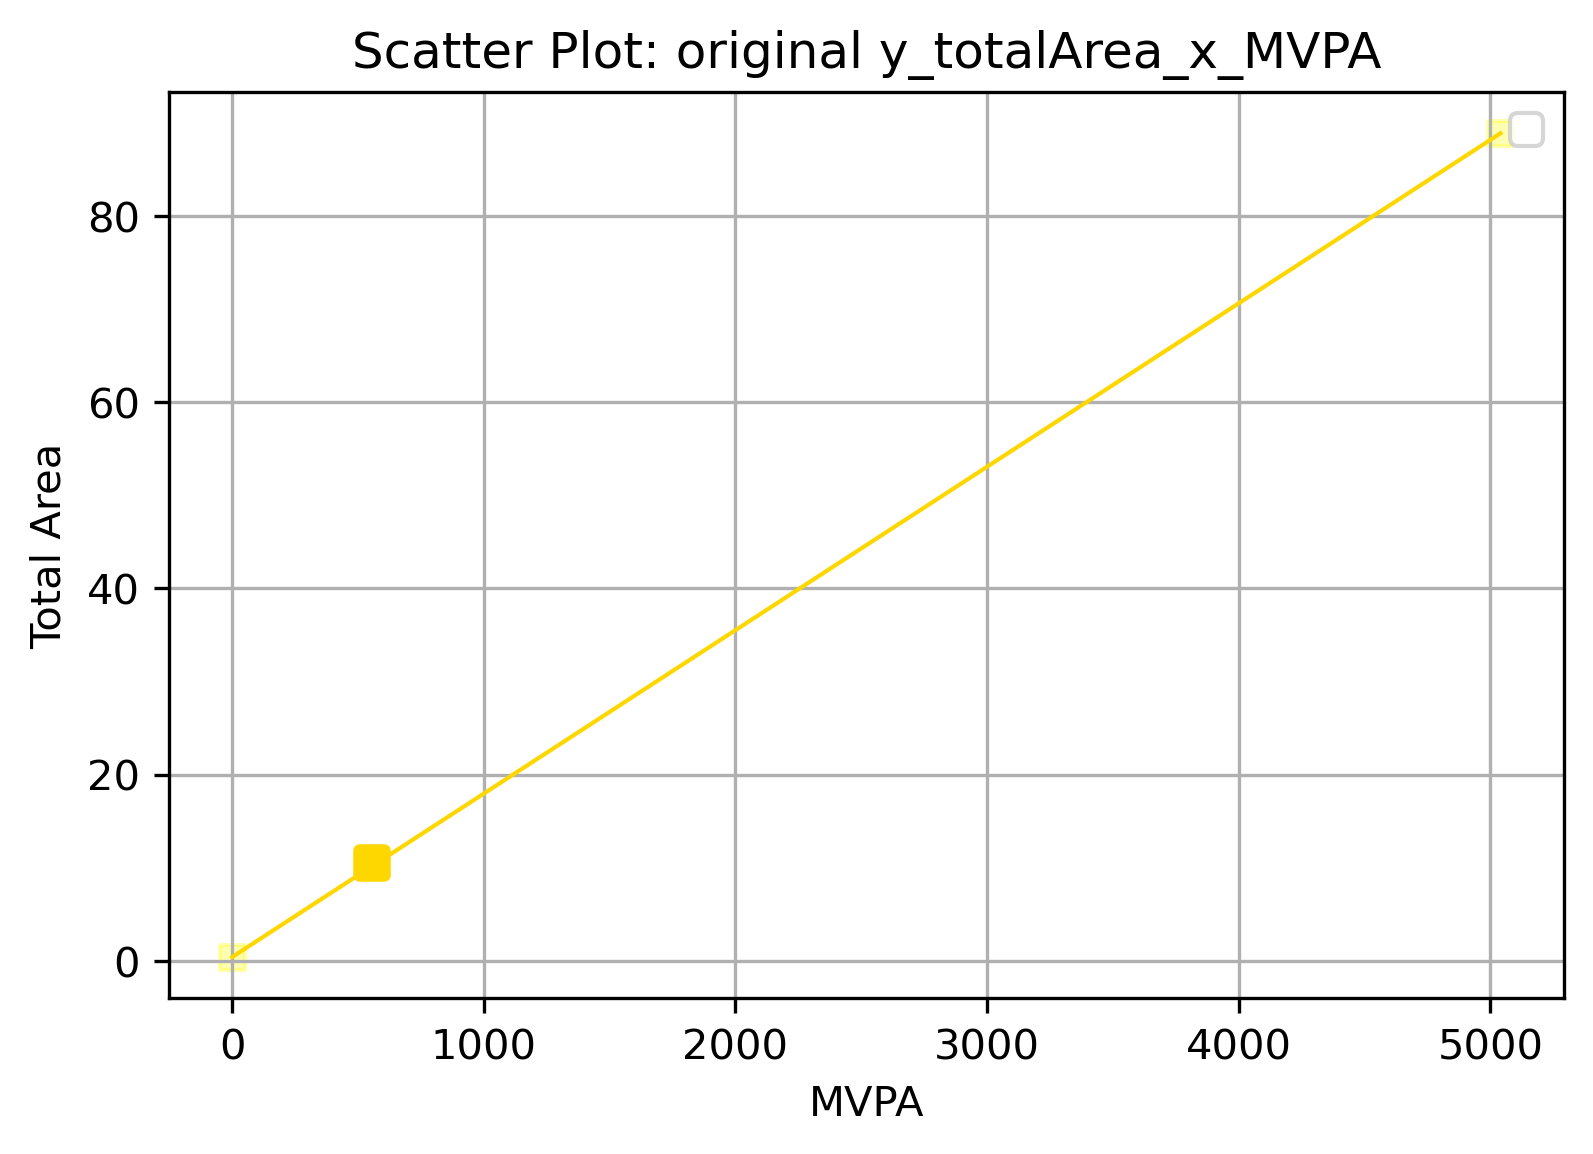

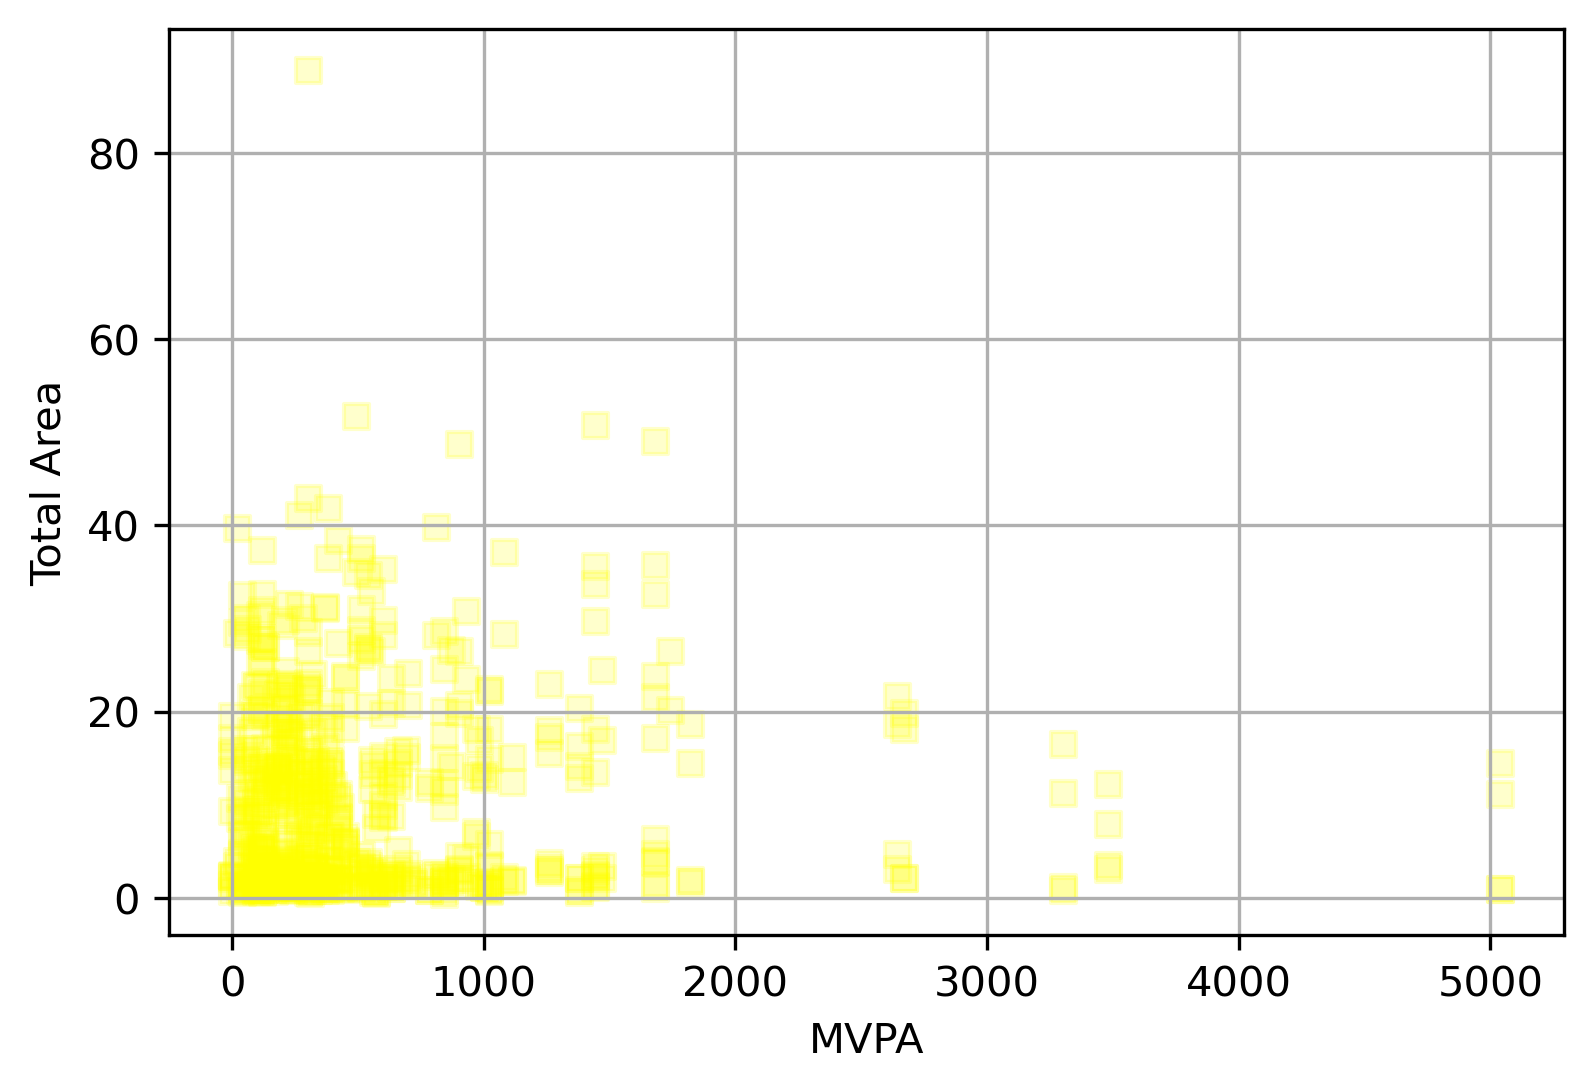


------------------ y_MVPA_x_totalArea ------------------


No handles with labels found to put in legend.



Range: x=[0.4102078939927178, 88.87804643616839] y=[0, 5040]

Mean: x=10.57034230807675 y=550.875

STD: x=10.564575995513435 y=673.5858193467549



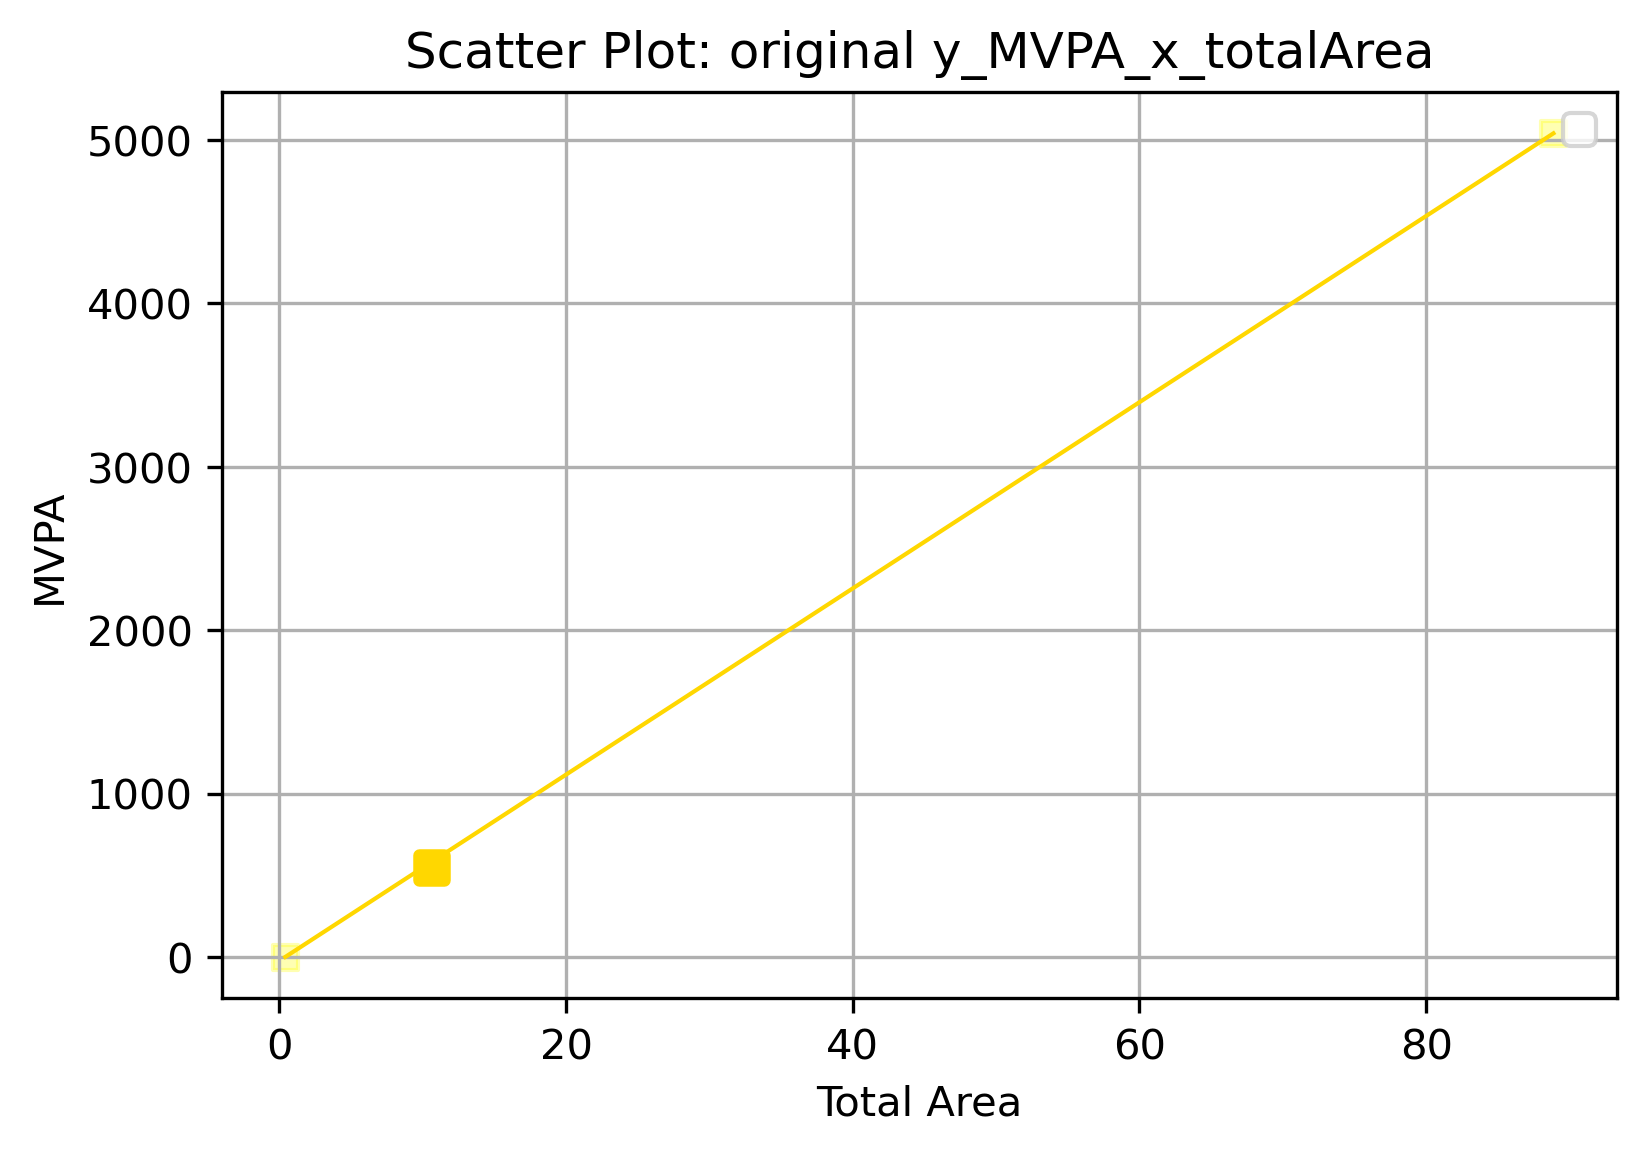

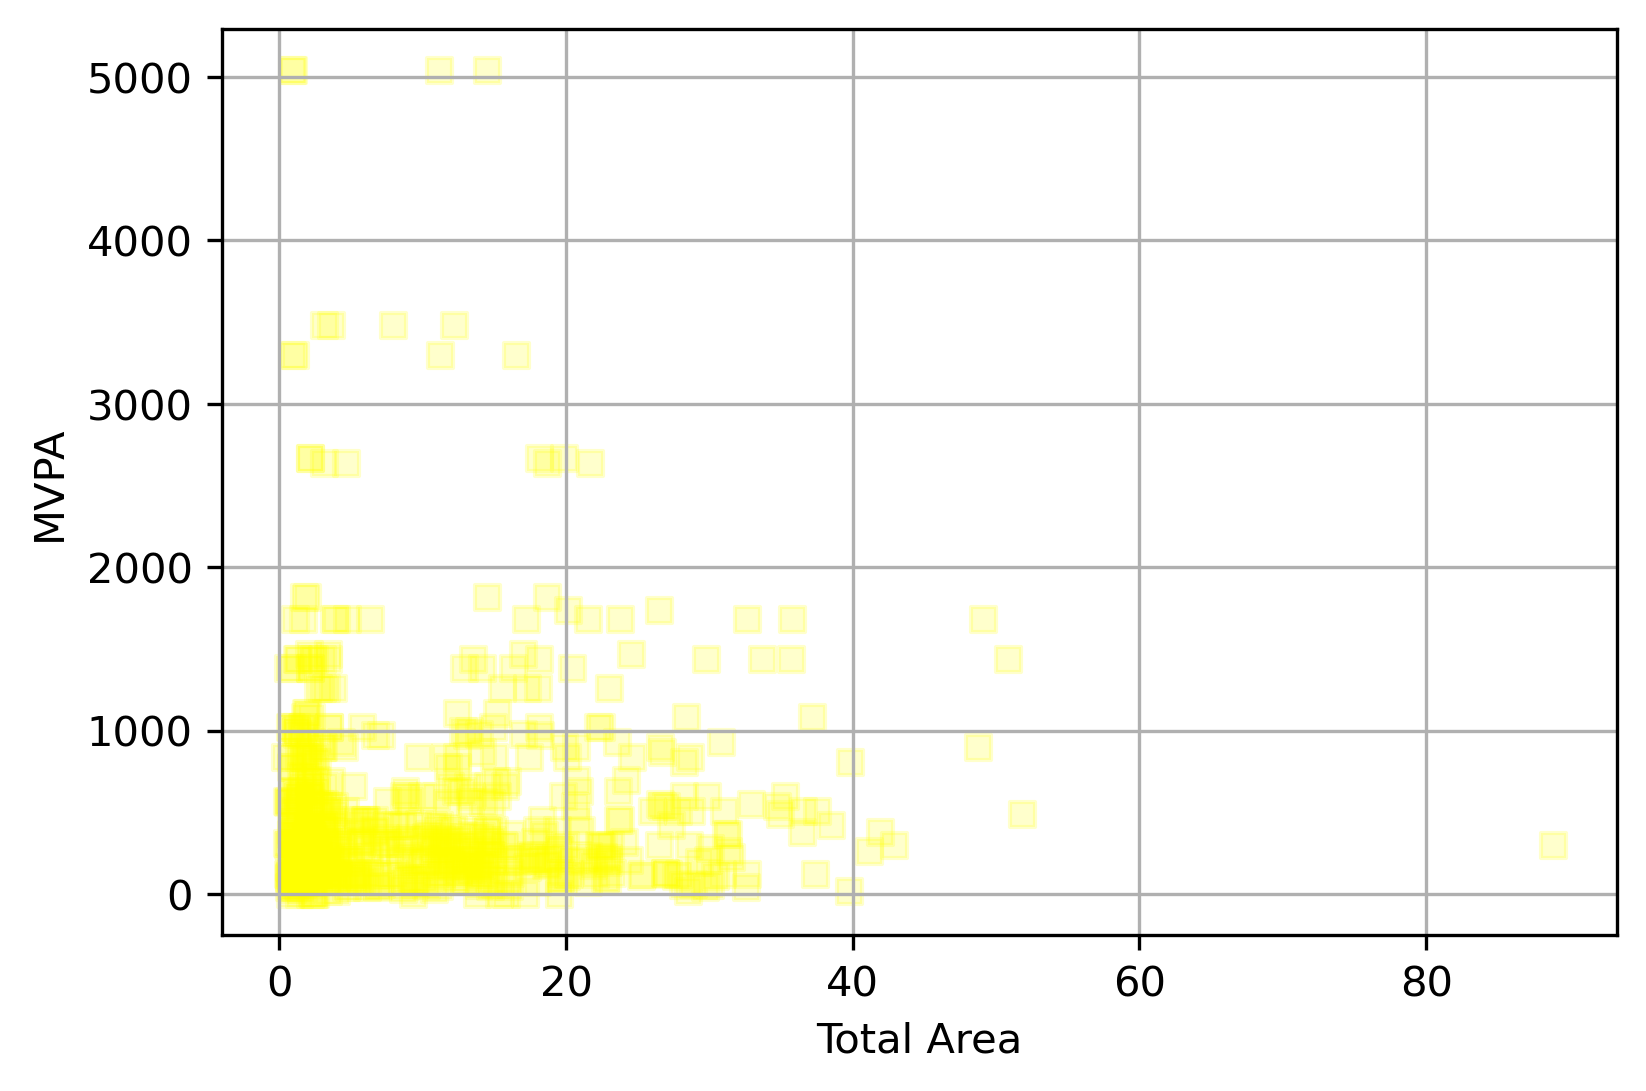


------------------ y_MVPA ------------------

Range: x=[0.1405488996666666, 3.897583579277778] y=[0, 5040]

Mean: x=1.0384700685459198 y=550.875

STD: x=0.6607561779845109 y=673.5858193467549


Range: x=[26.01134630582536, 541.4482963049761] y=[0, 5040]

Mean: x=131.0218621588279 y=550.875

STD: x=86.38056683338019 y=673.5858193467549


Range: x=[0.4335947042144584, 9.025642545507186] y=[0, 5040]

Mean: x=2.1840617129326185 y=550.875

STD: x=1.4399160999063207 y=673.5858193467549


Range: x=[0.347529162, 9.292425413222222] y=[0, 5040]

Mean: x=1.9422836695060746 y=550.875

STD: x=1.2368485414132397 y=673.5858193467549


Range: x=[0.4102078939927178, 88.87804643616839] y=[0, 5040]

Mean: x=10.570342308076757 y=550.875

STD: x=10.572839255279332 y=673.5858193467549



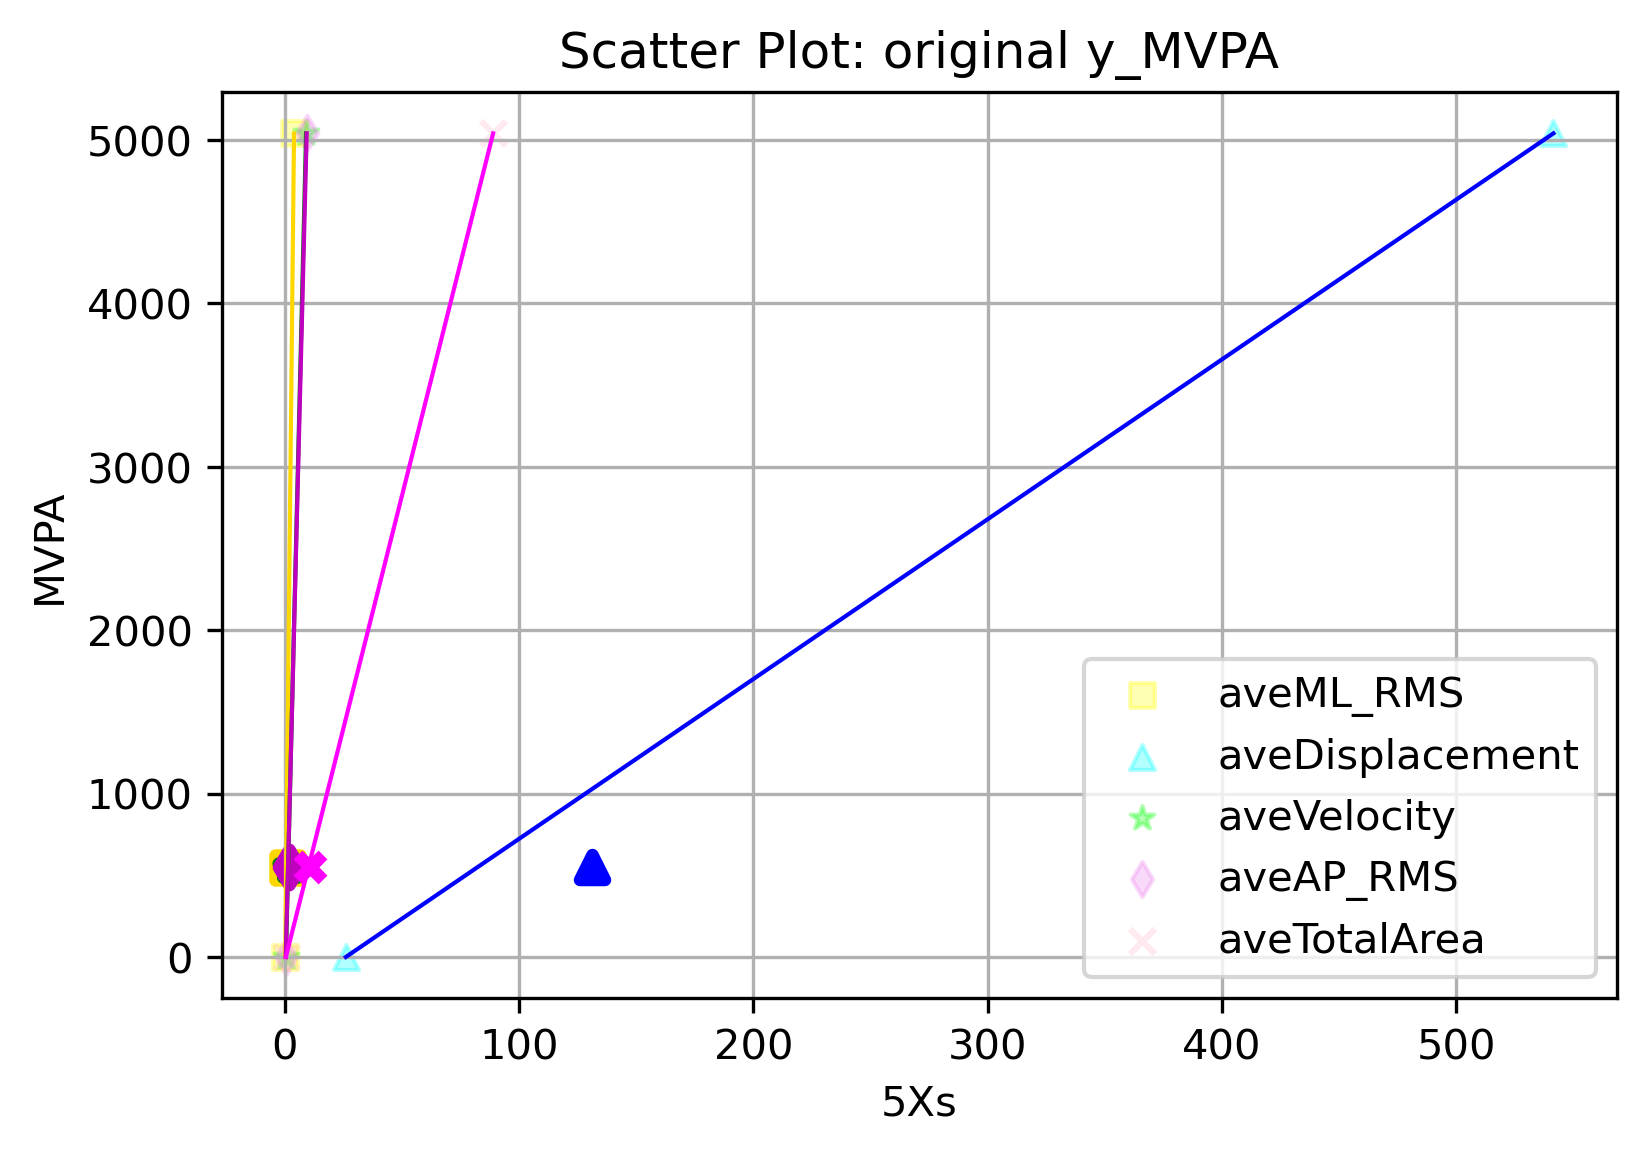

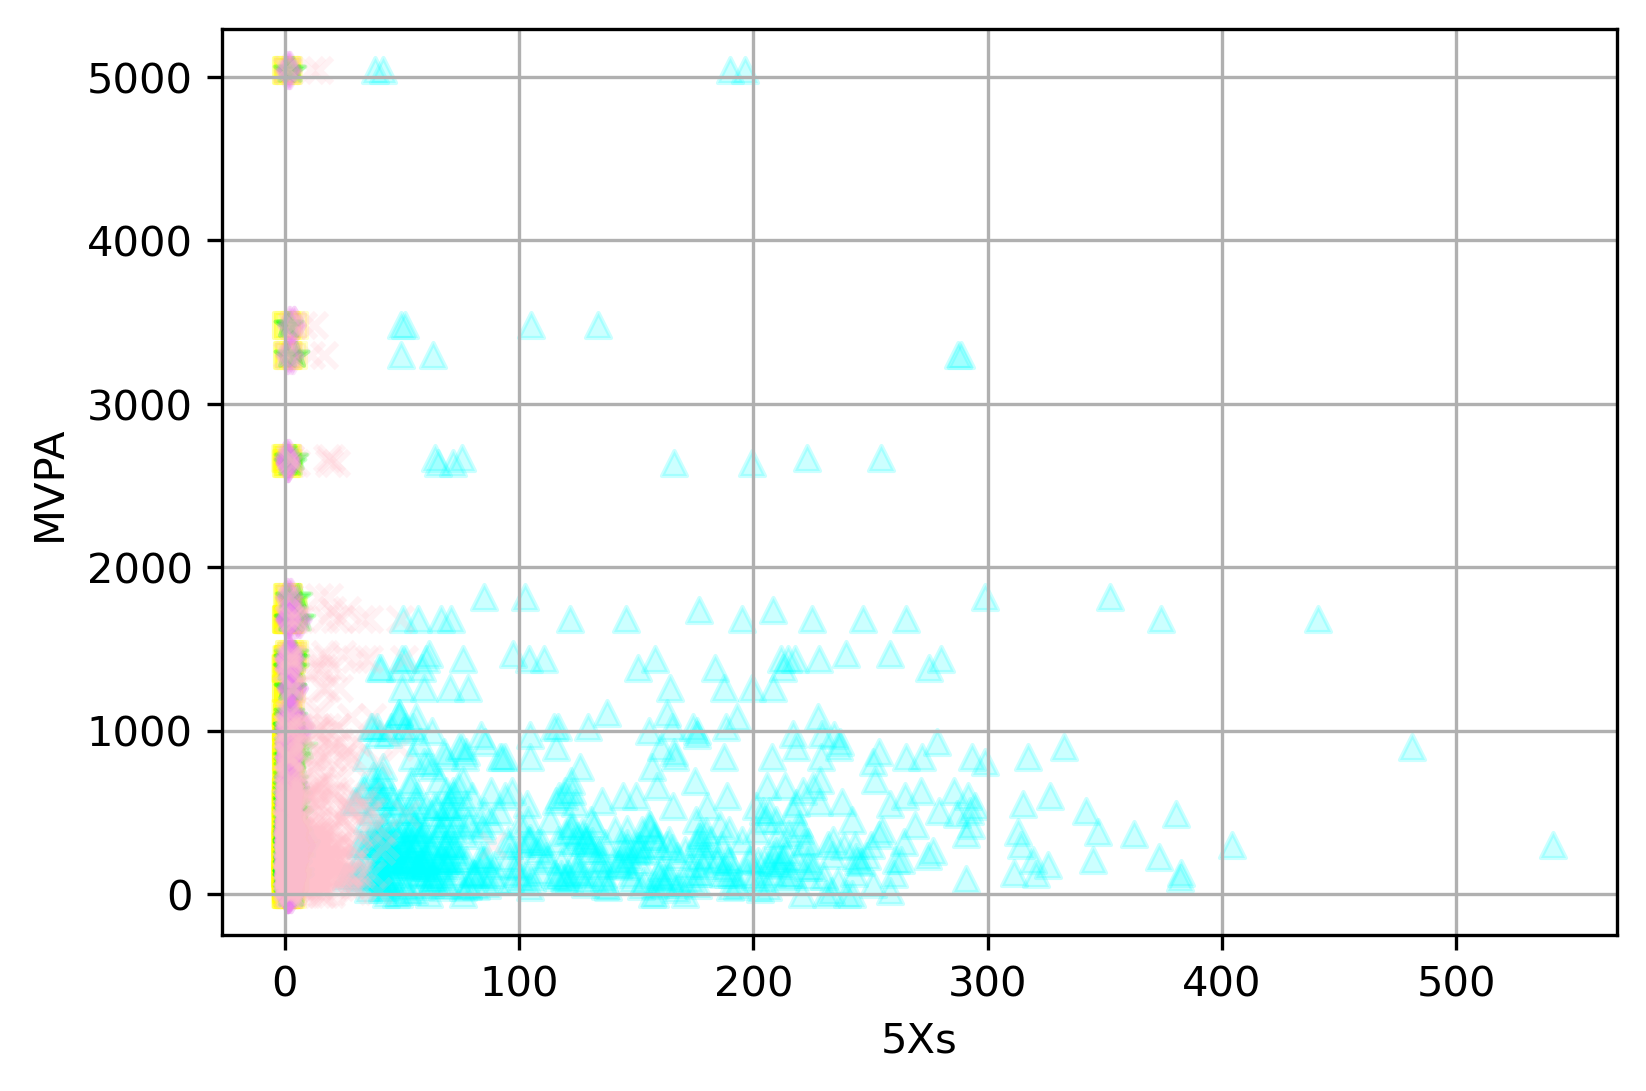


------------------ y_totalArea_x_IPAQ ------------------


No handles with labels found to put in legend.



Range: x=[1, 3] y=[0.4102078939927178, 88.87804643616839]

Mean: x=2.5 y=10.570342308076757

STD: x=0.7310095758606723 y=10.572839255279332



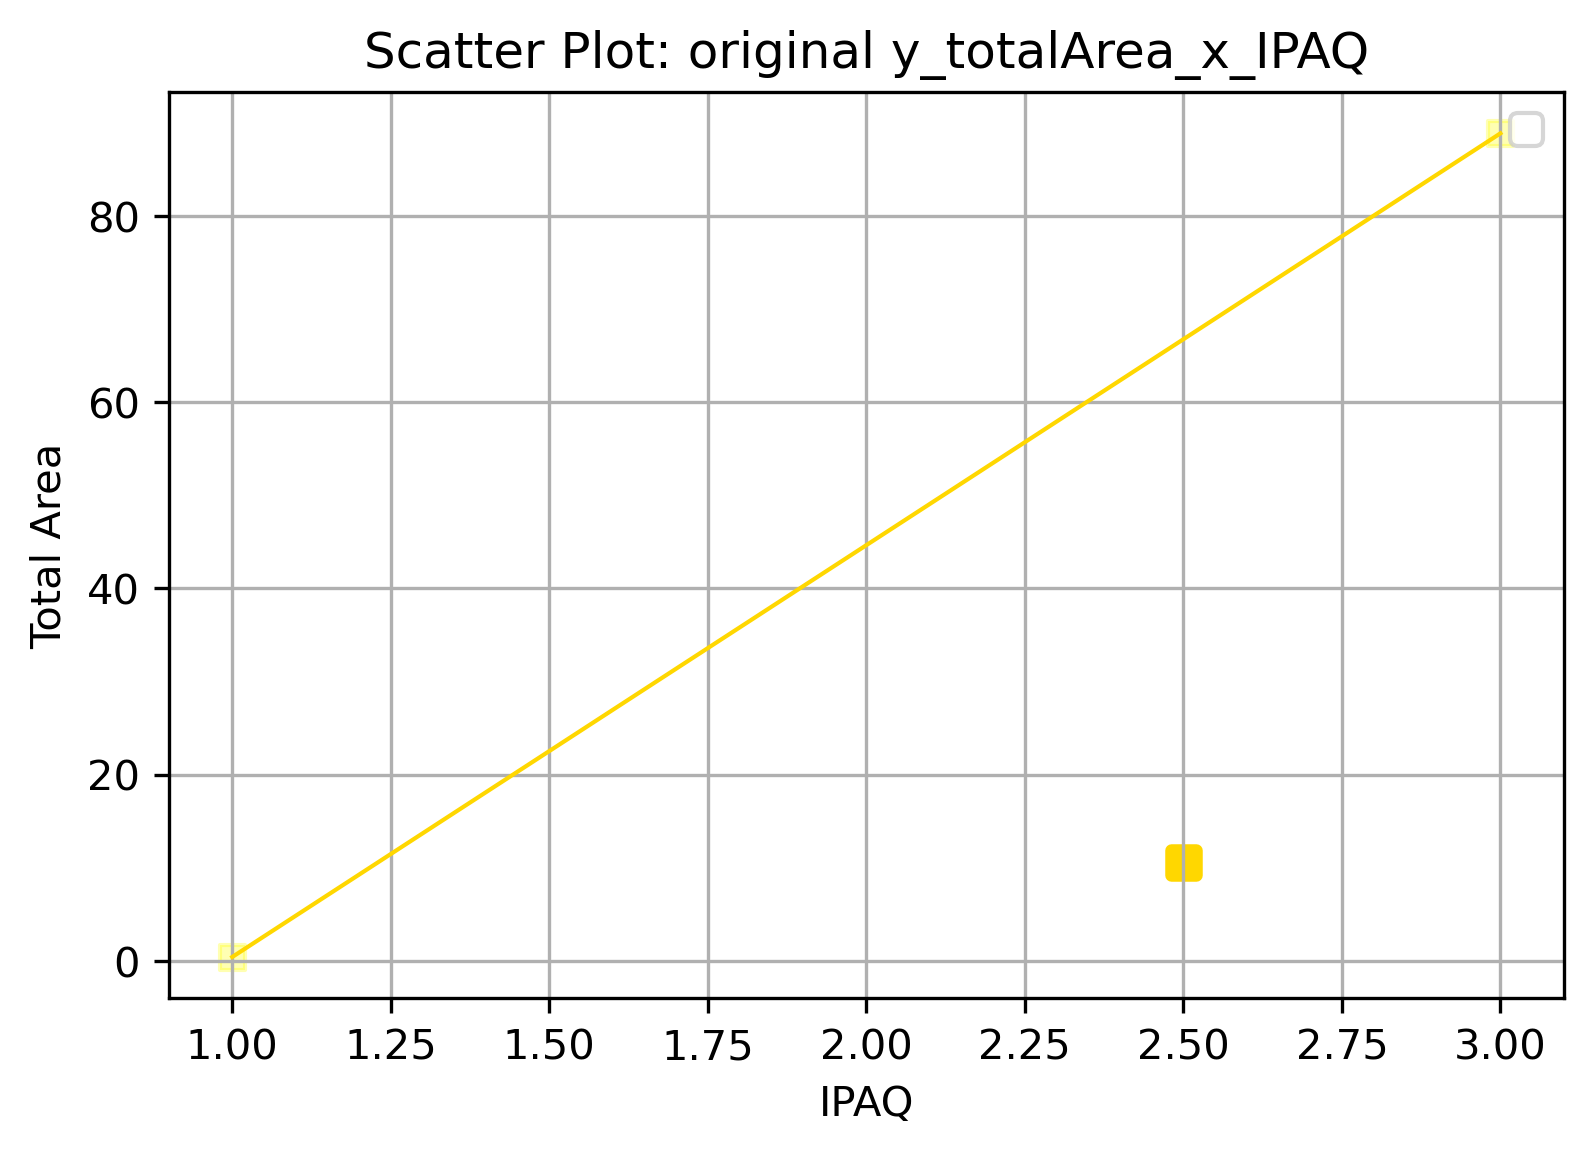

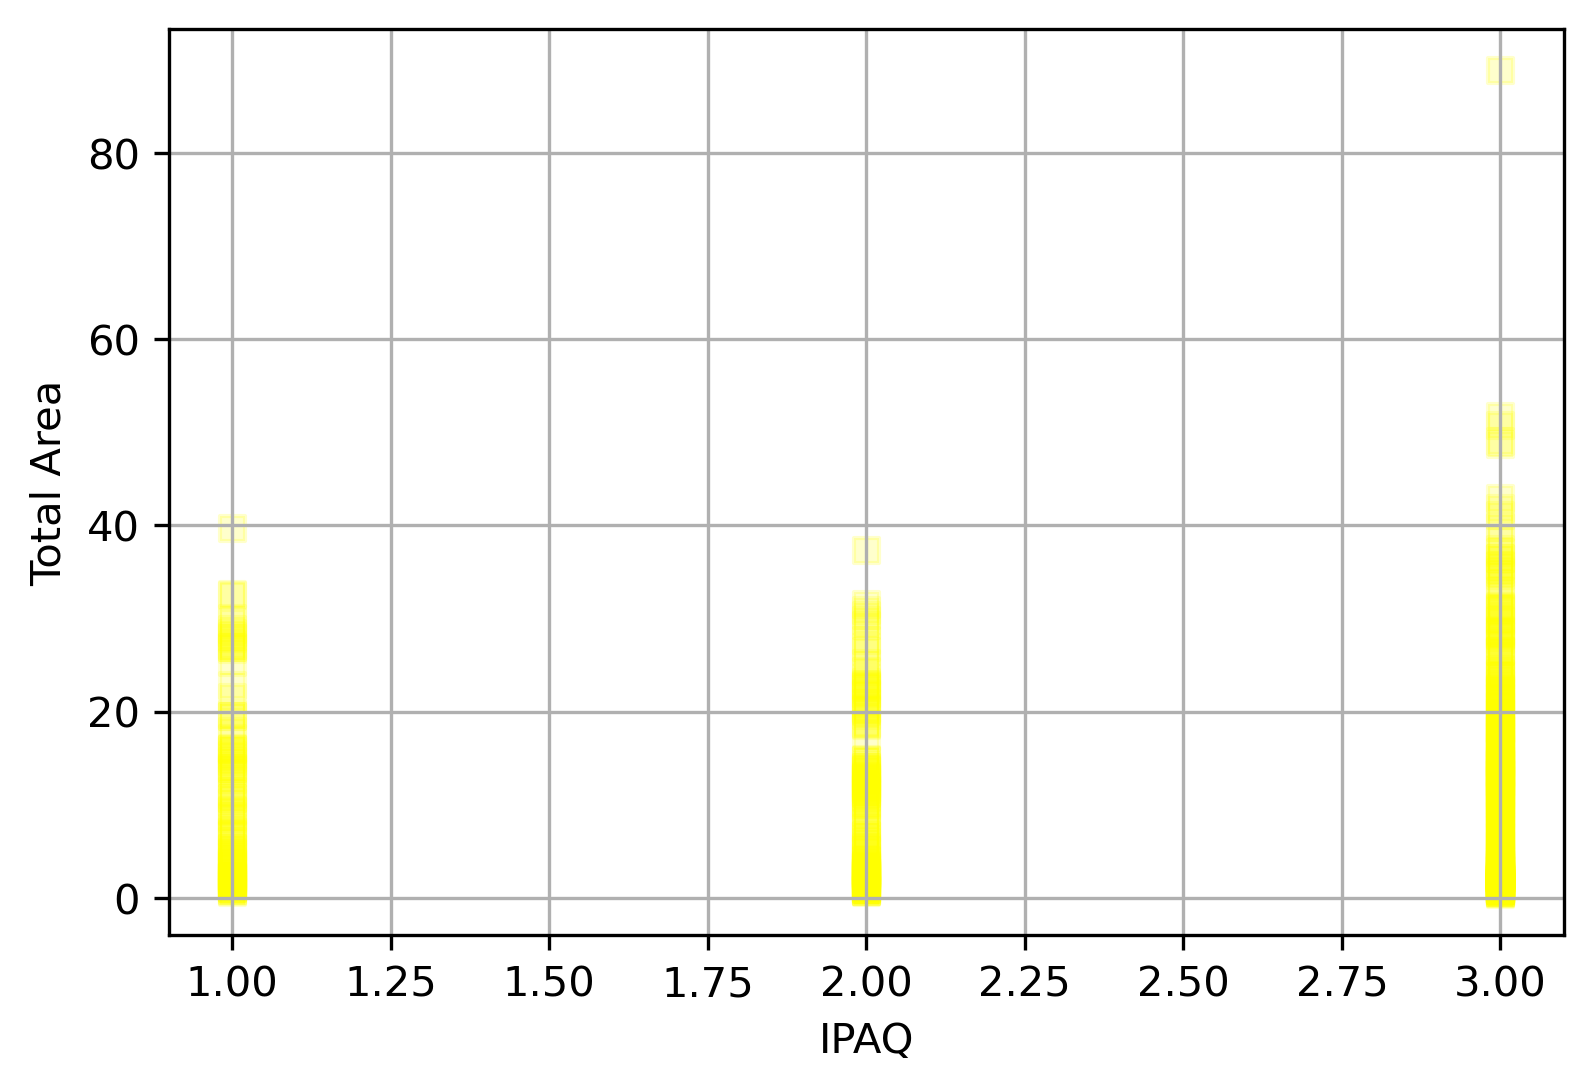


------------------ y_IPAQ_x_totalArea ------------------


No handles with labels found to put in legend.



Range: x=[0.4102078939927178, 88.87804643616839] y=[1, 3]

Mean: x=10.57034230807675 y=2.5

STD: x=10.564575995513435 y=0.7315813472236931



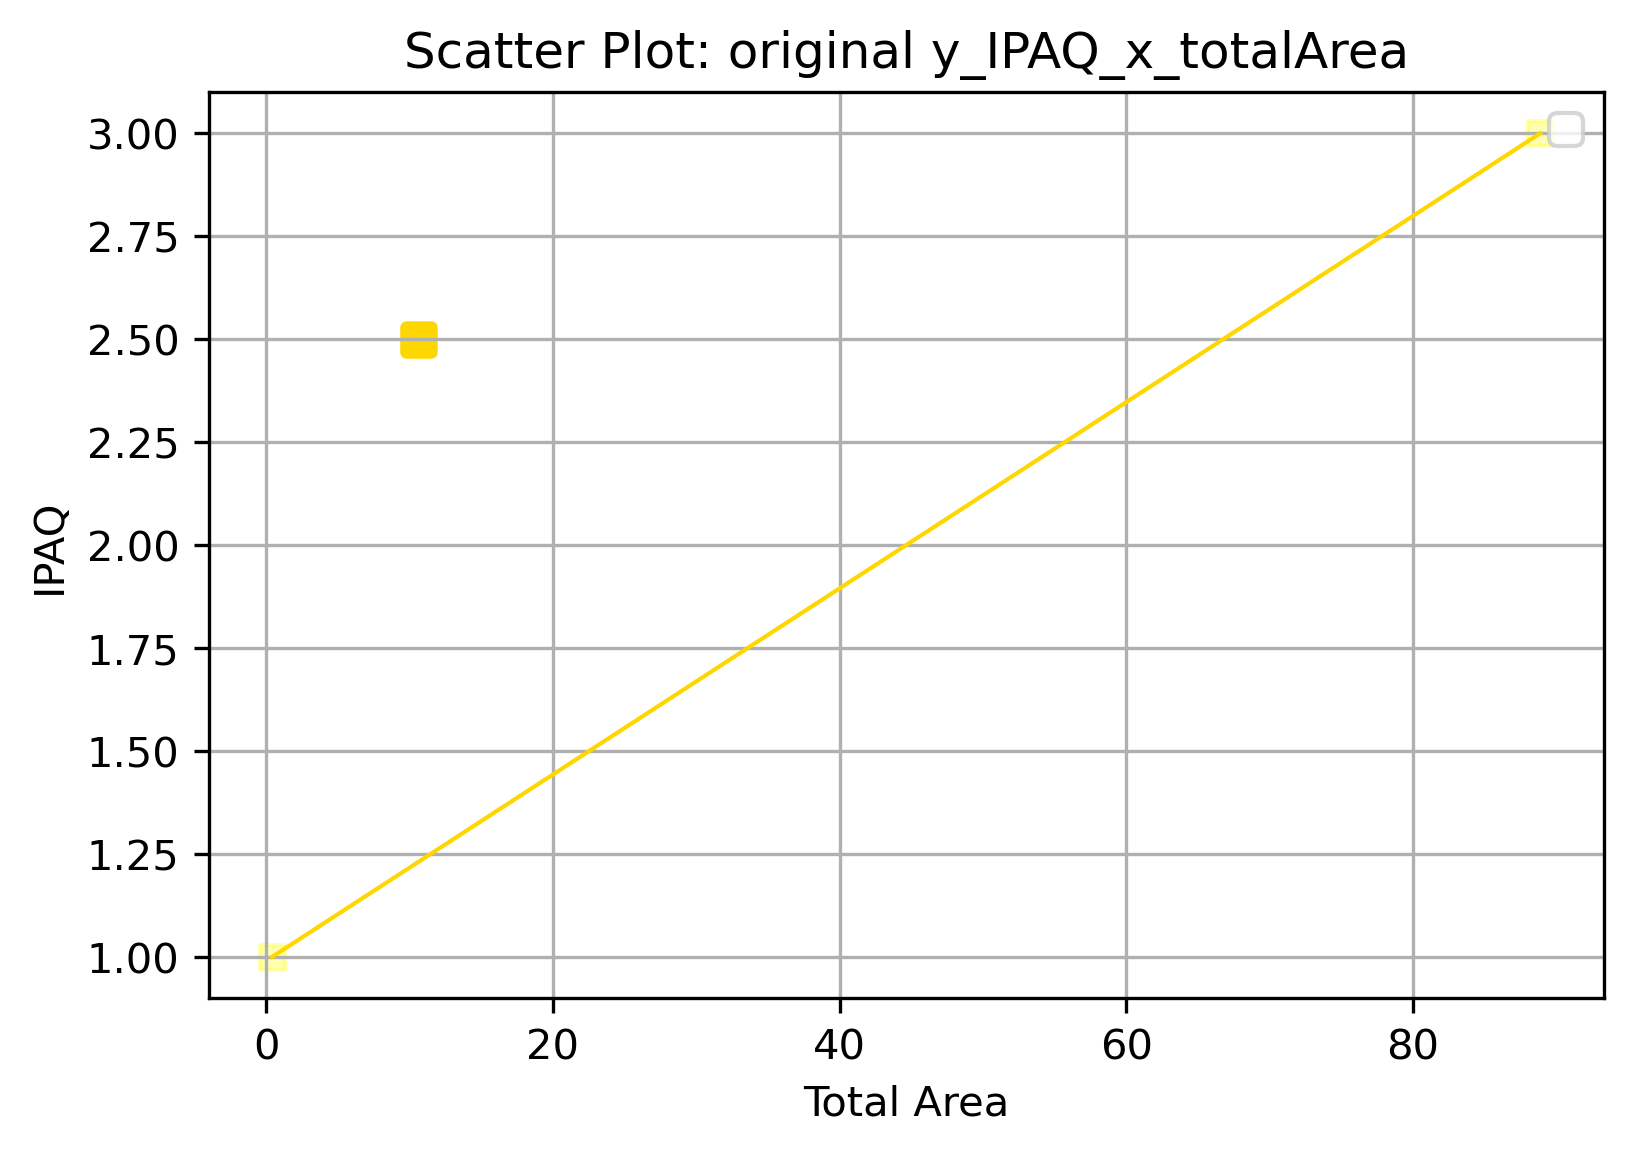

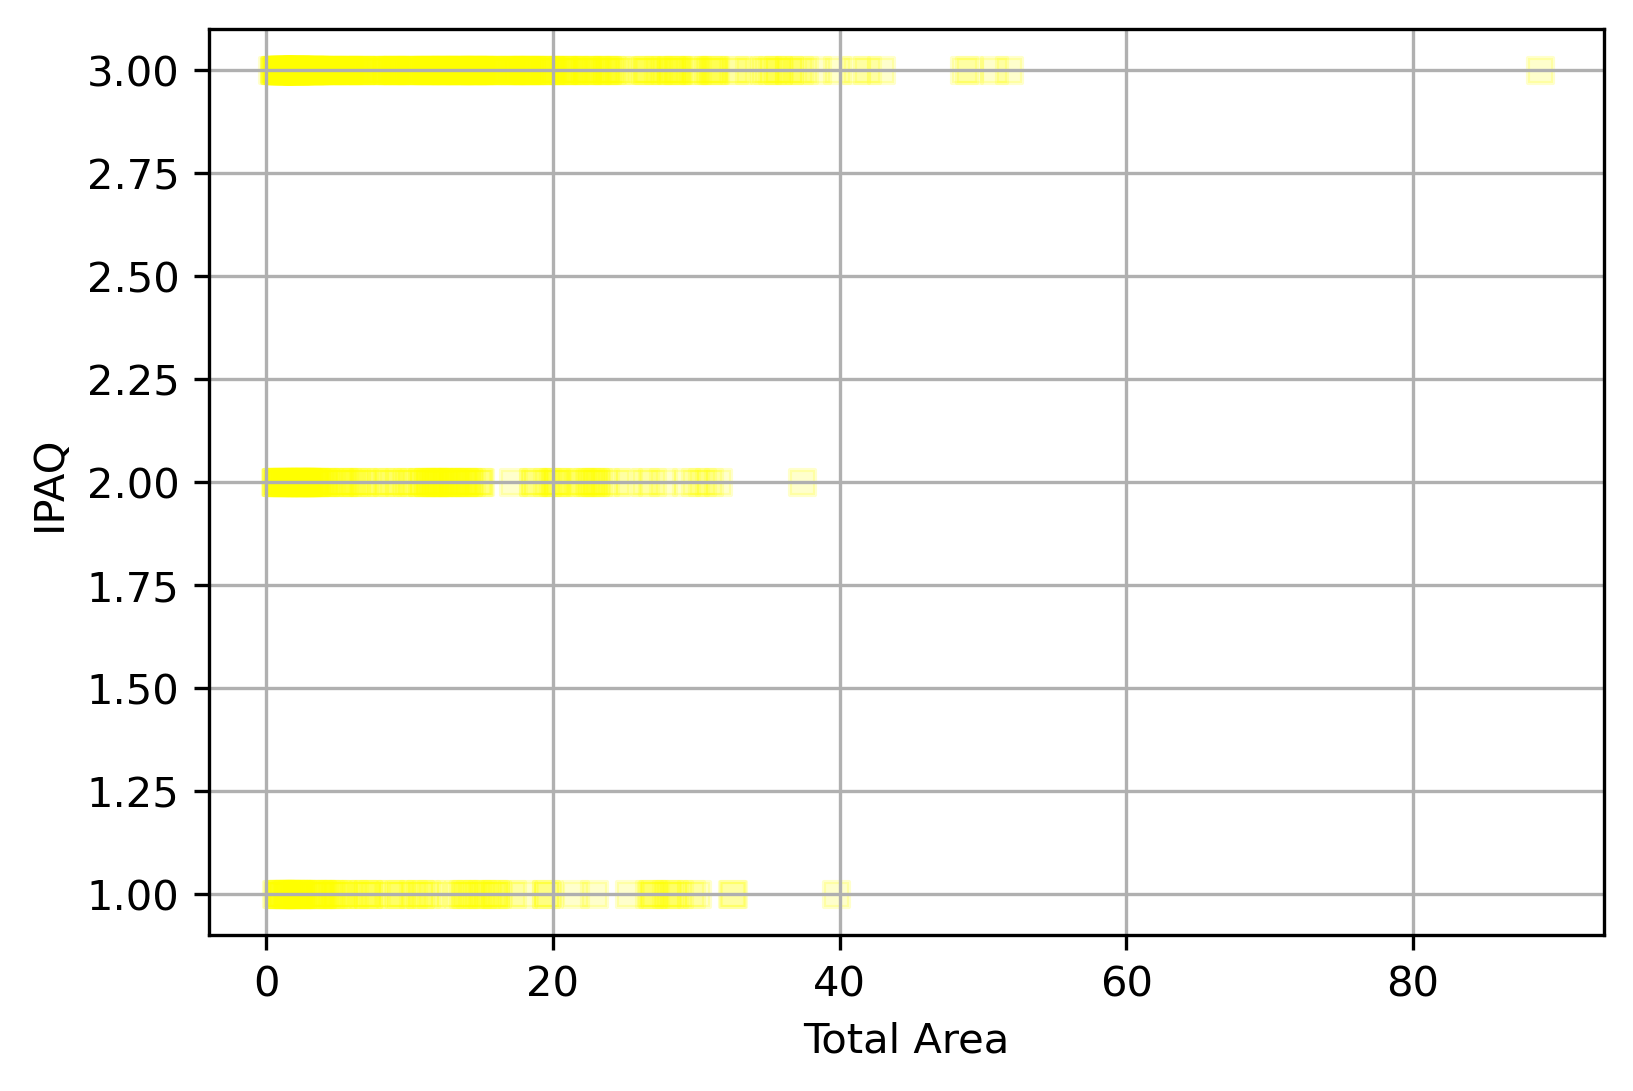


------------------ y_IPAQ ------------------

Range: x=[0.1405488996666666, 3.897583579277778] y=[1, 3]

Mean: x=1.0384700685459198 y=2.5

STD: x=0.6607561779845109 y=0.7315813472236931


Range: x=[26.01134630582536, 541.4482963049761] y=[1, 3]

Mean: x=131.0218621588279 y=2.5

STD: x=86.38056683338019 y=0.7315813472236931


Range: x=[0.4335947042144584, 9.025642545507186] y=[1, 3]

Mean: x=2.1840617129326185 y=2.5

STD: x=1.4399160999063207 y=0.7315813472236931


Range: x=[0.347529162, 9.292425413222222] y=[1, 3]

Mean: x=1.9422836695060746 y=2.5

STD: x=1.2368485414132397 y=0.7315813472236931


Range: x=[0.4102078939927178, 88.87804643616839] y=[1, 3]

Mean: x=10.570342308076757 y=2.5

STD: x=10.572839255279332 y=0.7315813472236931



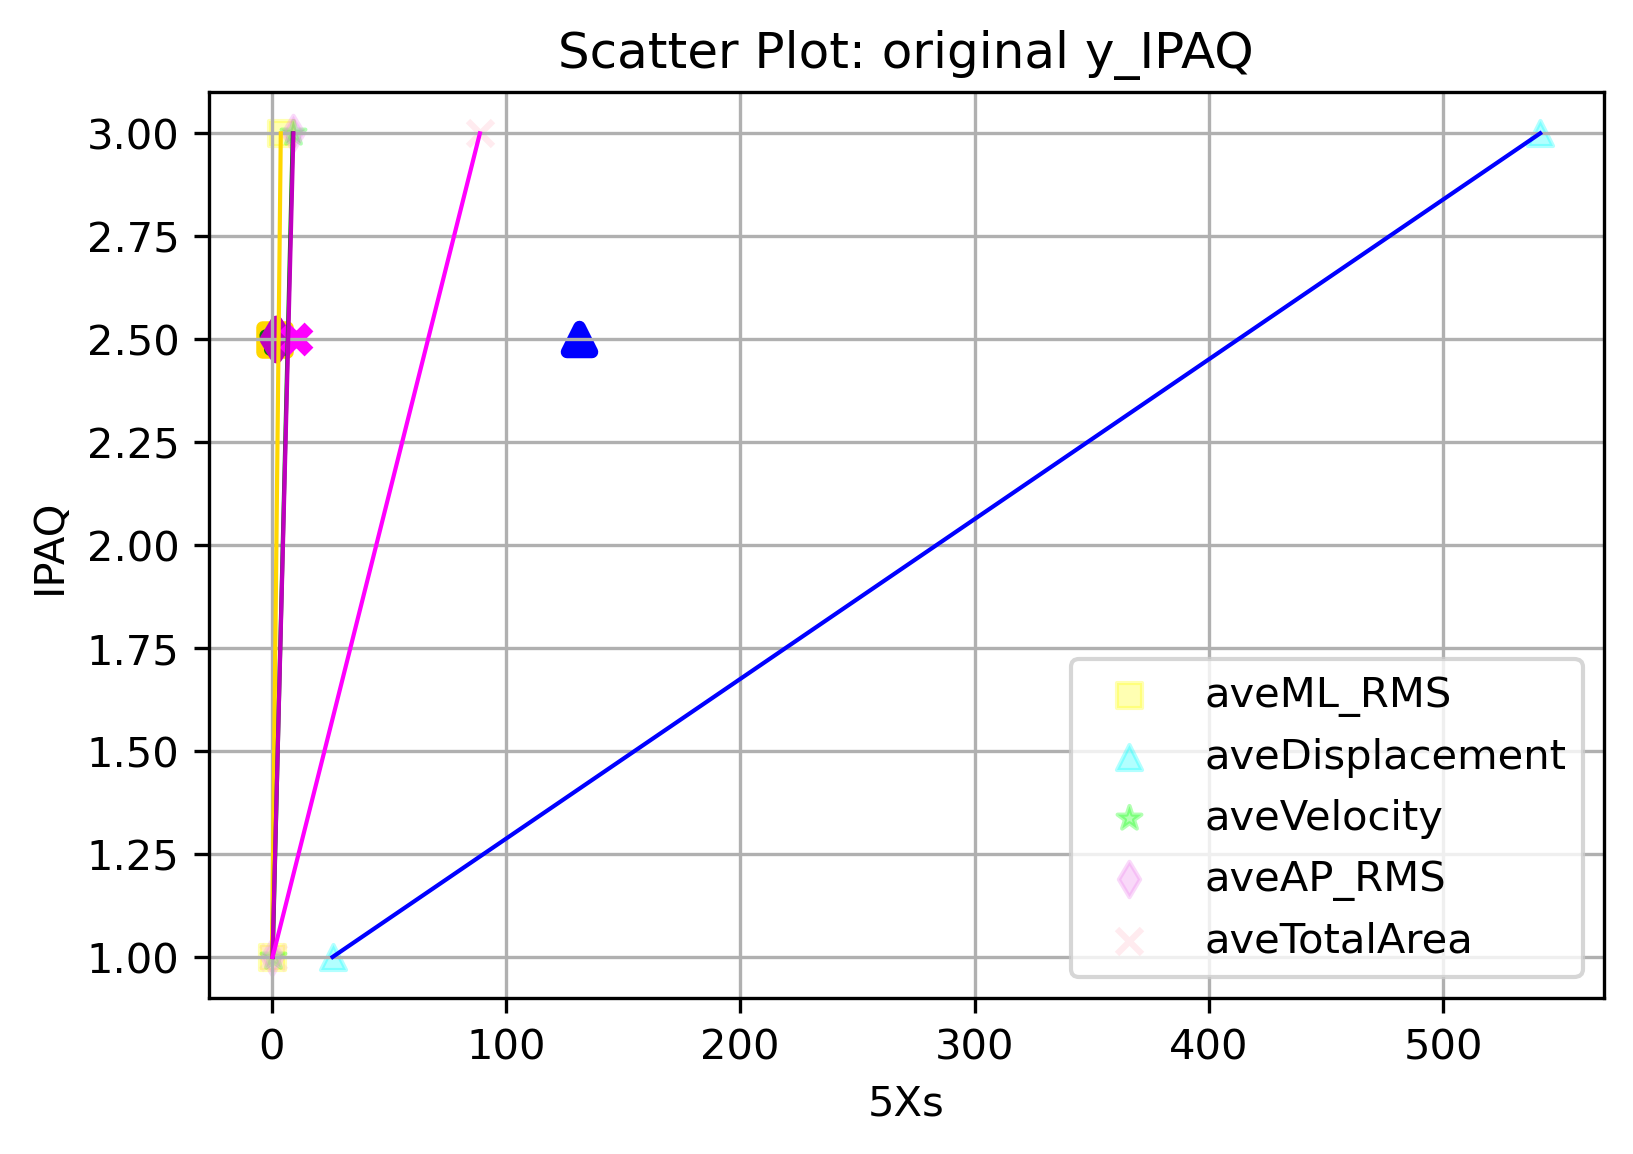

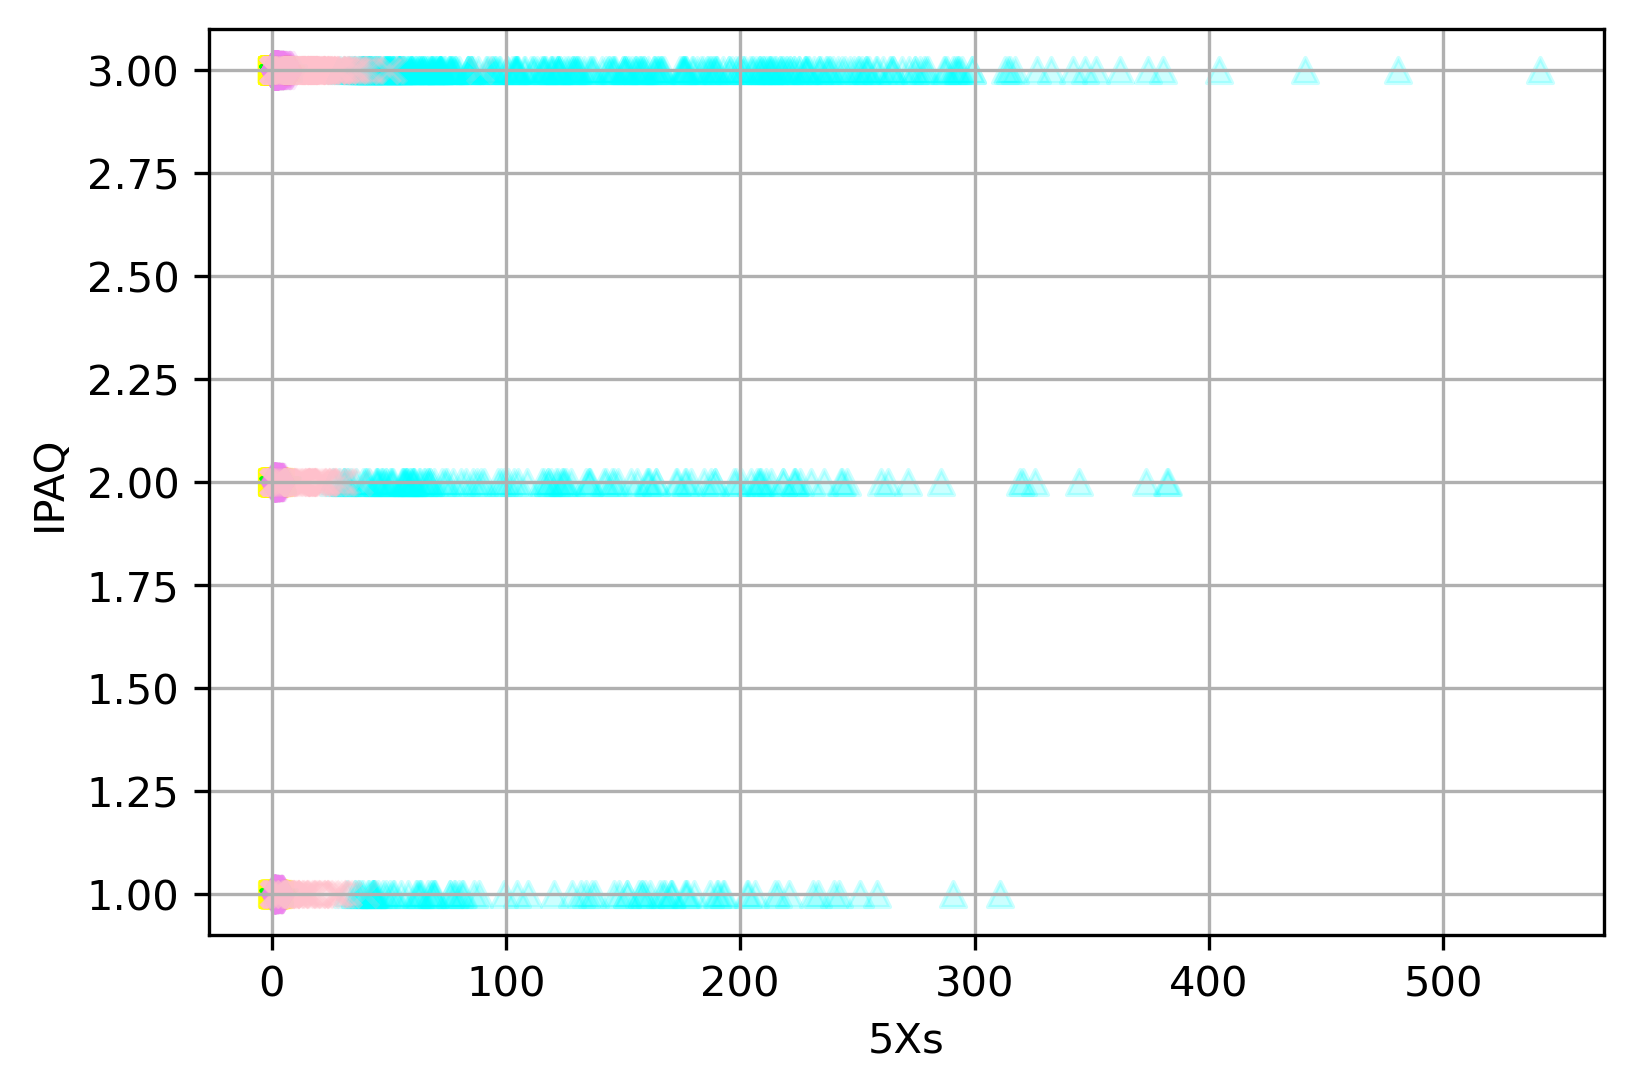


------------------ y_totalArea ------------------

Range: x=[0.1405488996666666, 3.897583579277778] y=[0.4102078939927178, 88.87804643616839]

Mean: x=1.0384700685459198 y=10.570342308076757

STD: x=0.6607561779845109 y=10.572839255279332


Range: x=[26.01134630582536, 541.4482963049761] y=[0.4102078939927178, 88.87804643616839]

Mean: x=131.0218621588279 y=10.570342308076757

STD: x=86.38056683338019 y=10.572839255279332


Range: x=[0.4335947042144584, 9.025642545507186] y=[0.4102078939927178, 88.87804643616839]

Mean: x=2.1840617129326185 y=10.570342308076757

STD: x=1.4399160999063207 y=10.572839255279332


Range: x=[0.347529162, 9.292425413222222] y=[0.4102078939927178, 88.87804643616839]

Mean: x=1.9422836695060746 y=10.570342308076757

STD: x=1.2368485414132397 y=10.572839255279332


Range: x=[0, 5040] y=[0.4102078939927178, 88.87804643616839]

Mean: x=550.875 y=10.570342308076757

STD: x=673.5858193467549 y=10.572839255279332


Range: x=[1, 3] y=[0.4102078939927178, 88.87804643

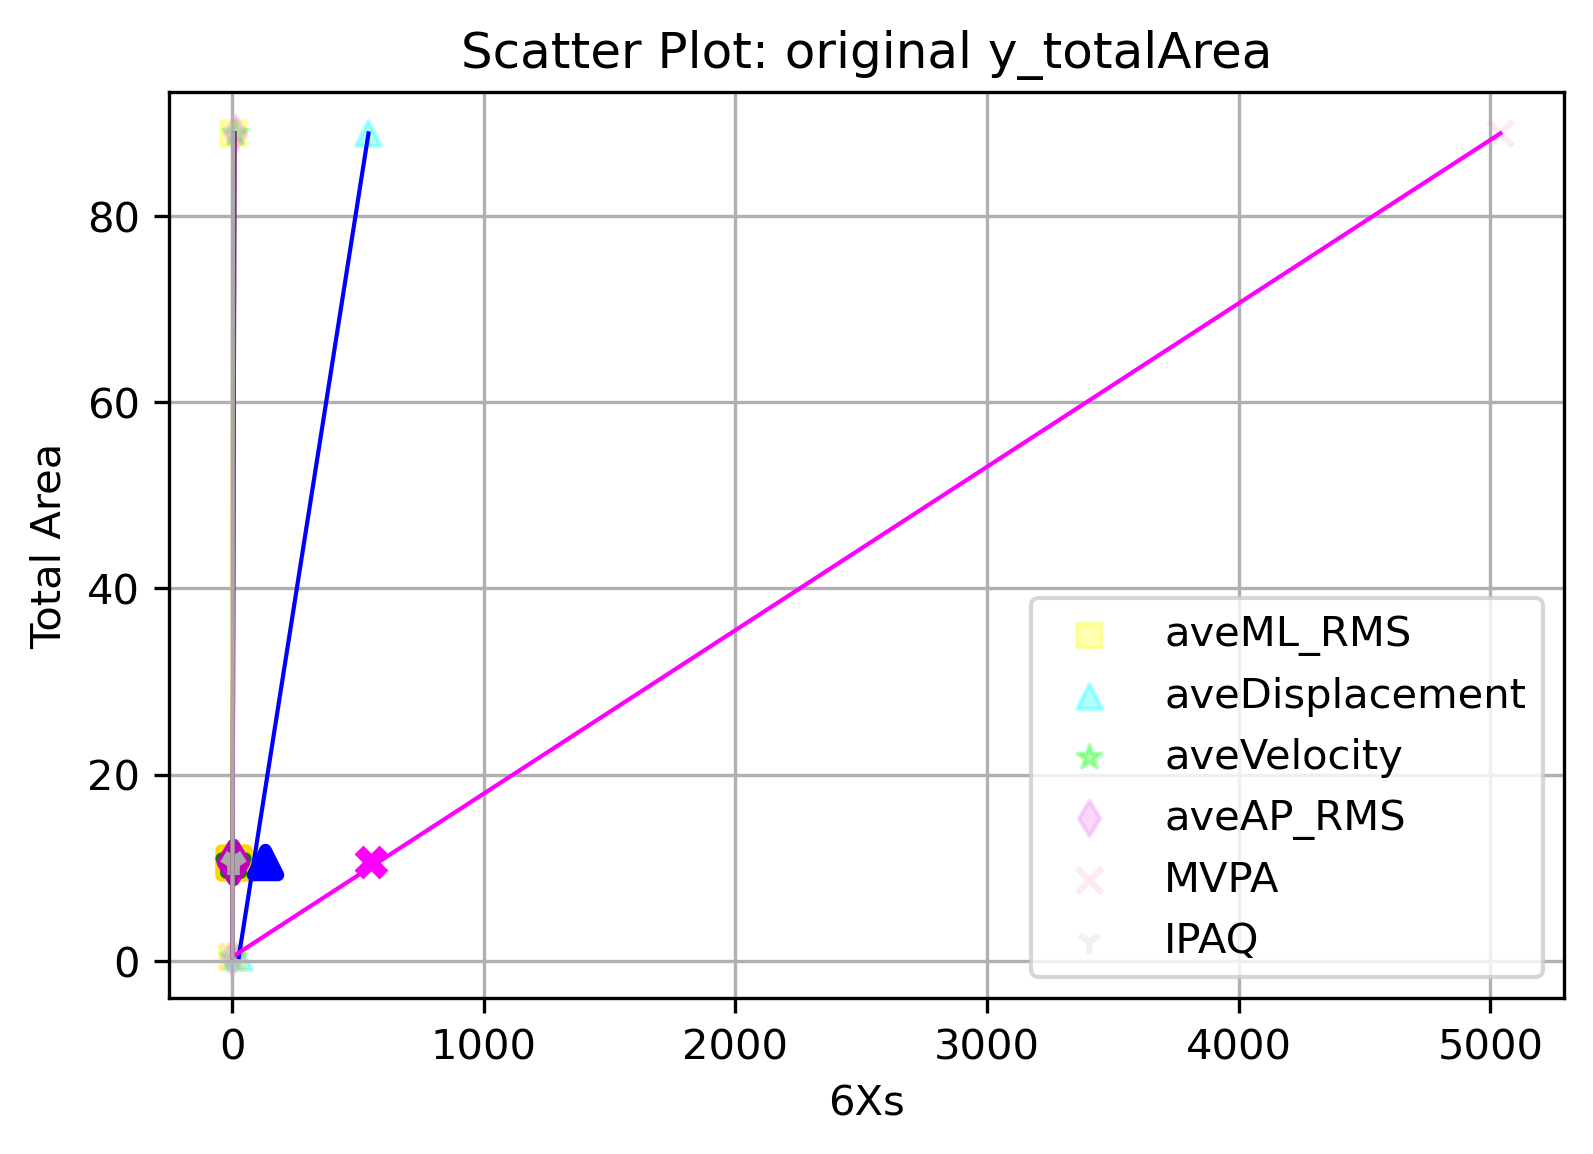

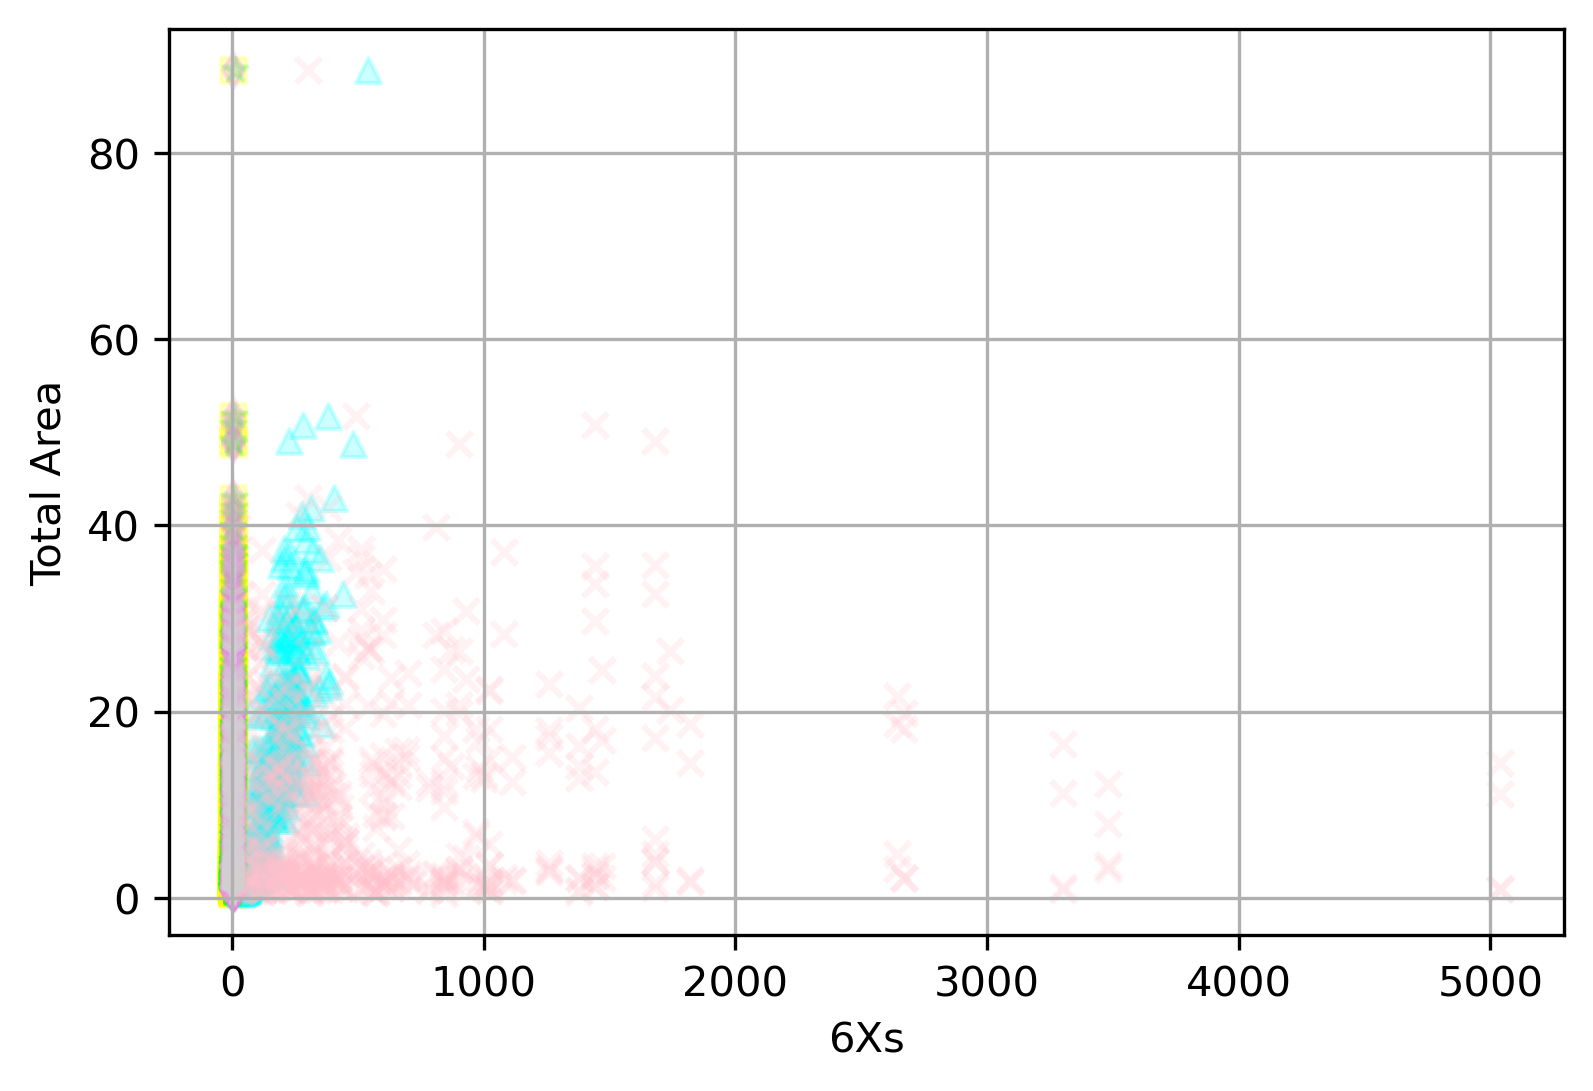

In [4]:
if __name__ == '__main__':
    checks = ['y_totalArea_x_MVPA', 'y_MVPA_x_totalArea', 'y_MVPA',
             'y_totalArea_x_IPAQ', 'y_IPAQ_x_totalArea', 'y_IPAQ',
             'y_totalArea']
    loadfile = '/BDS/variables.xlsx'
    savefile = '/original'
    
    txt = path_project + '/original/original.txt'
    f1 = open(txt, 'a')
    
    for check in checks:
        print("\n------------------ %s ------------------" %check)
        f1.write("\n------------------ %s ------------------" %check)
        test = plot(check, loadfile, savefile)
        test.scatter()
        
    f1.close()